**Data Preprocessing**

Importing Libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import optuna

Loading the dataset


In [55]:
df = pd.read_csv('forestfires.csv') #loads the dataset for Portugal wildfires
print(df.head(), '\n') #displays the first five rows of the dataset
print(df.info(), '\n') #displays summary information and the column names and datatypes of the dataset
print(df.describe()) #displays the statistical summary of the numerical columns of the dataset

   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-nu

Handling of missing values and duplicate instances 

In [56]:
#checks for duplicates and missing values before cleaning 
print("duplicates:", df.duplicated().sum())  #checks for duplicates  
print("missing values:", df.isnull().sum().sum()) #checks for missing values

#cleans the dataset for both duplicates and missing values 
df.drop_duplicates(inplace=True) #removes duplicates 
df.dropna(inplace=True) #removes any missing values 

# confirms that duplicates and missing values have been removed
print("duplicates:", df.duplicated().sum())  #checks for duplicates  
print("missing values:", df.isnull().sum().sum()) #checks for missing values

duplicates: 4
missing values: 0
duplicates: 0
missing values: 0


**Data Visualisation and Analysis**

Monthly fire occurence visualisation and analysis


Total Fires Recorded per Month:
        Total Fires Recorded
month                      
jan                       2
feb                      20
mar                      53
apr                       9
may                       2
jun                      16
jul                      32
aug                     182
sep                     172
oct                      15
nov                       1
dec                       9


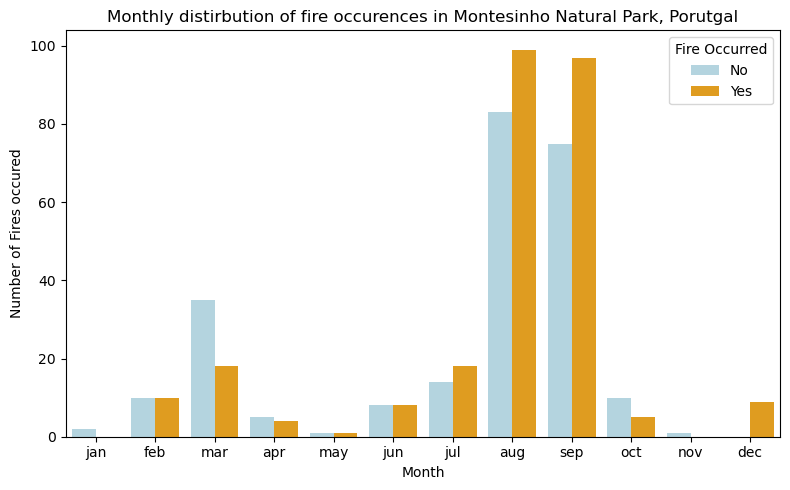

In [57]:
df['fire_occurred'] = df['area'].apply(lambda x: 'Yes' if x > 0 else 'No') #creates a new column to indicate if a fire occured or not by using the area burned column

month_order = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'] #sets the order of months for plotting

fire_recorded = df.groupby(['month', 'fire_occurred']).size().unstack(fill_value=0) #counts the total number of no fires and fires recorded per month 

fire_table = pd.DataFrame({'Total Fires Recorded': fire_recorded.sum(axis=1)}).reindex(month_order) #creates a summary table of total fires recorded per month in the correct order
print("\nTotal Fires Recorded per Month:\n", fire_table) #prints the summary table for data analysis and visualisation 

#plots the monthly distribution of fires recorded vs no fires recorded using a countplot
plt.figure(figsize=(8, 5))
sns.countplot(
    data=df,
    x='month',
    hue='fire_occurred',       
    order=month_order,
    palette={'Yes':'orange','No':'lightblue'} #plots side by side bars for fire occured (orange) and no fire occured (lightblue)
)

plt.title("Monthly distirbution of fire occurences in Montesinho Natural Park, Porutgal")
plt.xlabel("Month")
plt.ylabel("Number of Fires occured")
plt.legend(title='Fire Occurred')
plt.tight_layout()
plt.show()

#reference: https://seaborn.pydata.org/tutorial/distributions.html
#reference : https://github.com/sai-manas/FWI_Predictor_ML/blob/main/notebook/Algerian_forest_ML_project.ipynb

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_33660\2650617504.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fire_recorded = df.groupby(['month', 'fire_occurred']).size().unstack(fill_value=0)  #counts the total number of no fires and fires recorded per month


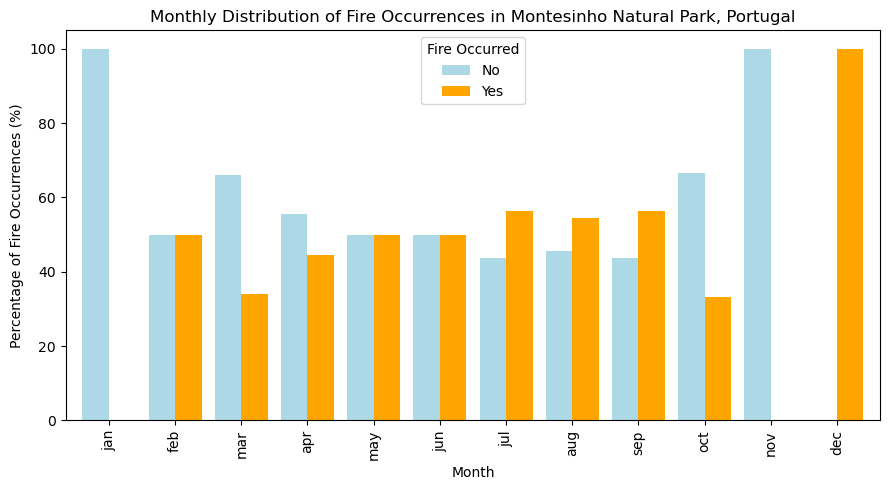

In [58]:
df['fire_occurred'] = df['area'].apply(lambda x: 'Yes' if x > 0 else 'No') #creates a new feature (feature engineering) to indicate if a fire occured or not using the area burned 

month_order = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'] #sets the month order for plotting the figure

df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True) #ensures the month column is catergorical (previously received a warning message)
fire_recorded = df.groupby(['month', 'fire_occurred']).size().unstack(fill_value=0)  #counts the total number of no fires and fires recorded per month 

fire_occured_percentage = fire_recorded.div(fire_recorded.sum(axis=1), axis=0) * 100 #calculates the perecentage of fires and no fires recorded for each month

fire_occured_percentage.plot(
    kind='bar',
    color=['lightblue', 'orange'], #plots side by side bars for percentage fire occured (orange) and percentage no fire occured (lightblue)
    figsize=(9, 5),
    width=0.8
)

plt.title("Monthly Distribution of Fire Occurrences in Montesinho Natural Park, Portugal")
plt.xlabel("Month")
plt.ylabel("Percentage of Fire Occurrences (%)")
plt.legend(title='Fire Occurred')
plt.tight_layout()
plt.show()

#reference: https://seaborn.pydata.org/tutorial/distributions.html
#reference: https://github.com/sai-manas/FWI_Predictor_ML/blob/main/notebook/Algerian_forest_ML_project.ipynb

Seasonal fire occurence visualisation and analysis

<Figure size 1000x2000 with 0 Axes>

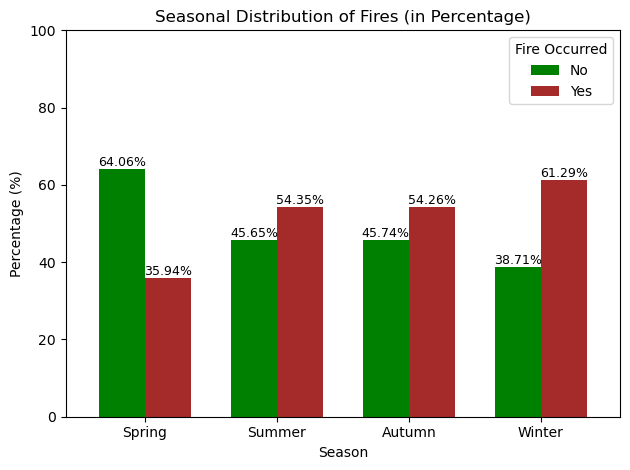

Seasonal Fire Occurrence Summary: 

fire_occurred  No Fire Recorded (No)  Fire Occurred (Yes)  Total Fires
season                                                                
Spring                            41                   23           64
Summer                           105                  125          230
Autumn                            86                  102          188
Winter                            12                   19           31


In [59]:
def get_season(month):     #function is used to map the months to their respective seasons
    spring = ["mar", "apr", "may"]
    summer = ["jun", "jul", "aug"]
    autumn = ["sep", "oct", "nov"]
    winter = ["dec", "jan", "feb"]
    if month in spring: return "Spring"
    if month in summer: return "Summer"
    if month in autumn: return "Autumn"
    if month in winter: return "Winter"

df["season"] = df["month"].apply(get_season) #reference: https://seasonsyear.com/Portugal
df['fire_occurred'] = df['area'].apply(lambda x: 'Yes' if x > 0 else 'No')
season_order = ["Spring", "Summer", "Autumn", "Winter"]
season_counts = df.groupby(['season', 'fire_occurred']).size().unstack(fill_value=0)


season_percent = (season_counts.div(season_counts.sum(axis=1), axis=0) * 100).reindex(season_order) #calculates the percentage fire occurences and non-fire occurrences per season


plt.figure(figsize=(10, 20))
ax = season_percent.plot(
    kind='bar',
    color={'Yes': 'brown', 'No': 'green'},
    #edgecolor='black',
    width=0.7
)
plt.ylim(0, 100)

plt.title("Seasonal Distribution of Fires (in Percentage)")
plt.xlabel("Season")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)
plt.legend(title='Fire Occurred')

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', fontsize=9, label_type='edge')  #adds the percentage value labels on top of each bar of the barplot 

plt.tight_layout()
plt.show()

#plots the seasonal fire occurrence as a summary table 
season_counts = df.groupby(["season", "fire_occurred"]).size().unstack(fill_value=0)
season_counts["Total Fires"] = season_counts.sum(axis=1)
season_order = ["Spring", "Summer", "Autumn", "Winter"]
season_counts = season_counts.reindex(season_order)
season_counts = season_counts.rename(columns={"Yes": "Fire Occurred (Yes)", "No": "No Fire Recorded (No)"})
print("Seasonal Fire Occurrence Summary: \n")
print(season_counts)

#reference: https://seaborn.pydata.org/tutorial/distributions.html
#reference: https://github.com/sai-manas/FWI_Predictor_ML/blob/main/notebook/Algerian_forest_ML_project.ipynb

Burned Area - Montesinho Natural Park 

Number of samples with burned area: 269
Number of samples with no burned area: 244


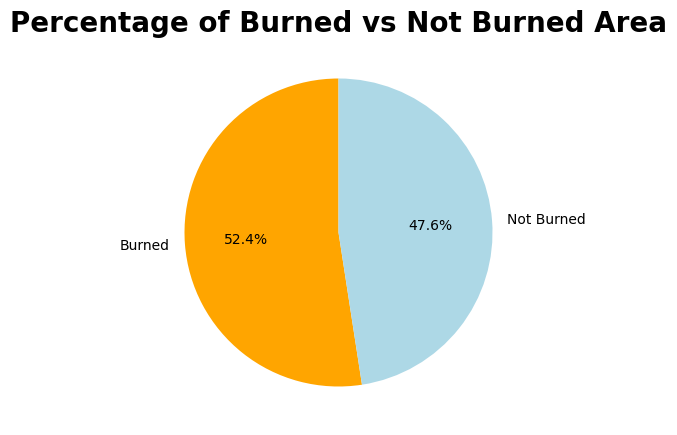

In [60]:
#plots the total burned area percentage vs not burned area percentage
burned_tot = (df['area'] > 0).sum()   
not_burned_tot = (df['area'] == 0).sum()

total = burned_tot + not_burned_tot
percentage = [burned_tot/total*100, not_burned_tot/total*100]

print(f"Number of samples with burned area: {burned_tot}")
print(f"Number of samples with no burned area: {not_burned_tot}")

plt.figure(figsize=(5, 5))
plt.pie(percentage, autopct="%1.1f%%", labels=["Burned","Not Burned"], 
        colors=['orange','lightblue'], startangle=90)
plt.title("Percentage of Burned vs Not Burned Area", weight="bold", fontsize=20)
plt.show()

#reference: https://github.com/sai-manas/FWI_Predictor_ML/blob/main/notebook/Algerian_forest_ML_project.ipynb

Correlation Heat Map 

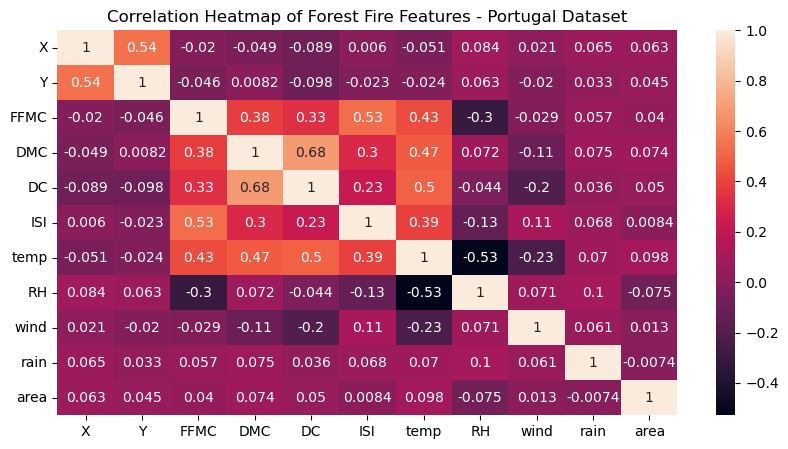

In [61]:
#plots the correlation heatmap - original 
corr_df = df.select_dtypes(include = [float, int])
corr_matrix = corr_df.corr()

plt.figure(figsize=(10, 5))
sns.heatmap(
    corr_matrix,
    annot=True,
)
plt.title("Correlation Heatmap of Forest Fire Features - Portugal Dataset")
plt.show()

#reference: https://python-graph-gallery.com/92-control-color-in-seaborn-heatmaps/
#reference: https://www.geeksforgeeks.org/python/how-to-create-a-seaborn-correlation-heatmap-in-python/

Handling of Catergorical Values 

In [62]:
#uses label encoding to map catergorical features to its respective numerical values for month, day, season, fire_occurred
month_map = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6,
             'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
day_map = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5, 'sat':6, 'sun':7}

season_map = {'Spring':1, 'Summer':2, 'Autumn':3, 'Winter':4}
fire_occurred_map = {'Yes':1, 'No':0}

df['month'] = df['month'].map(month_map)
df['day'] = df['day'].map(day_map)
df['season'] = df['season'].map(season_map)
df['fire_occurred'] = df['fire_occurred'].map(fire_occurred_map)

#reference: https://pandas.pydata.org/docs/dev/reference/api/pandas.Categorical.map.html

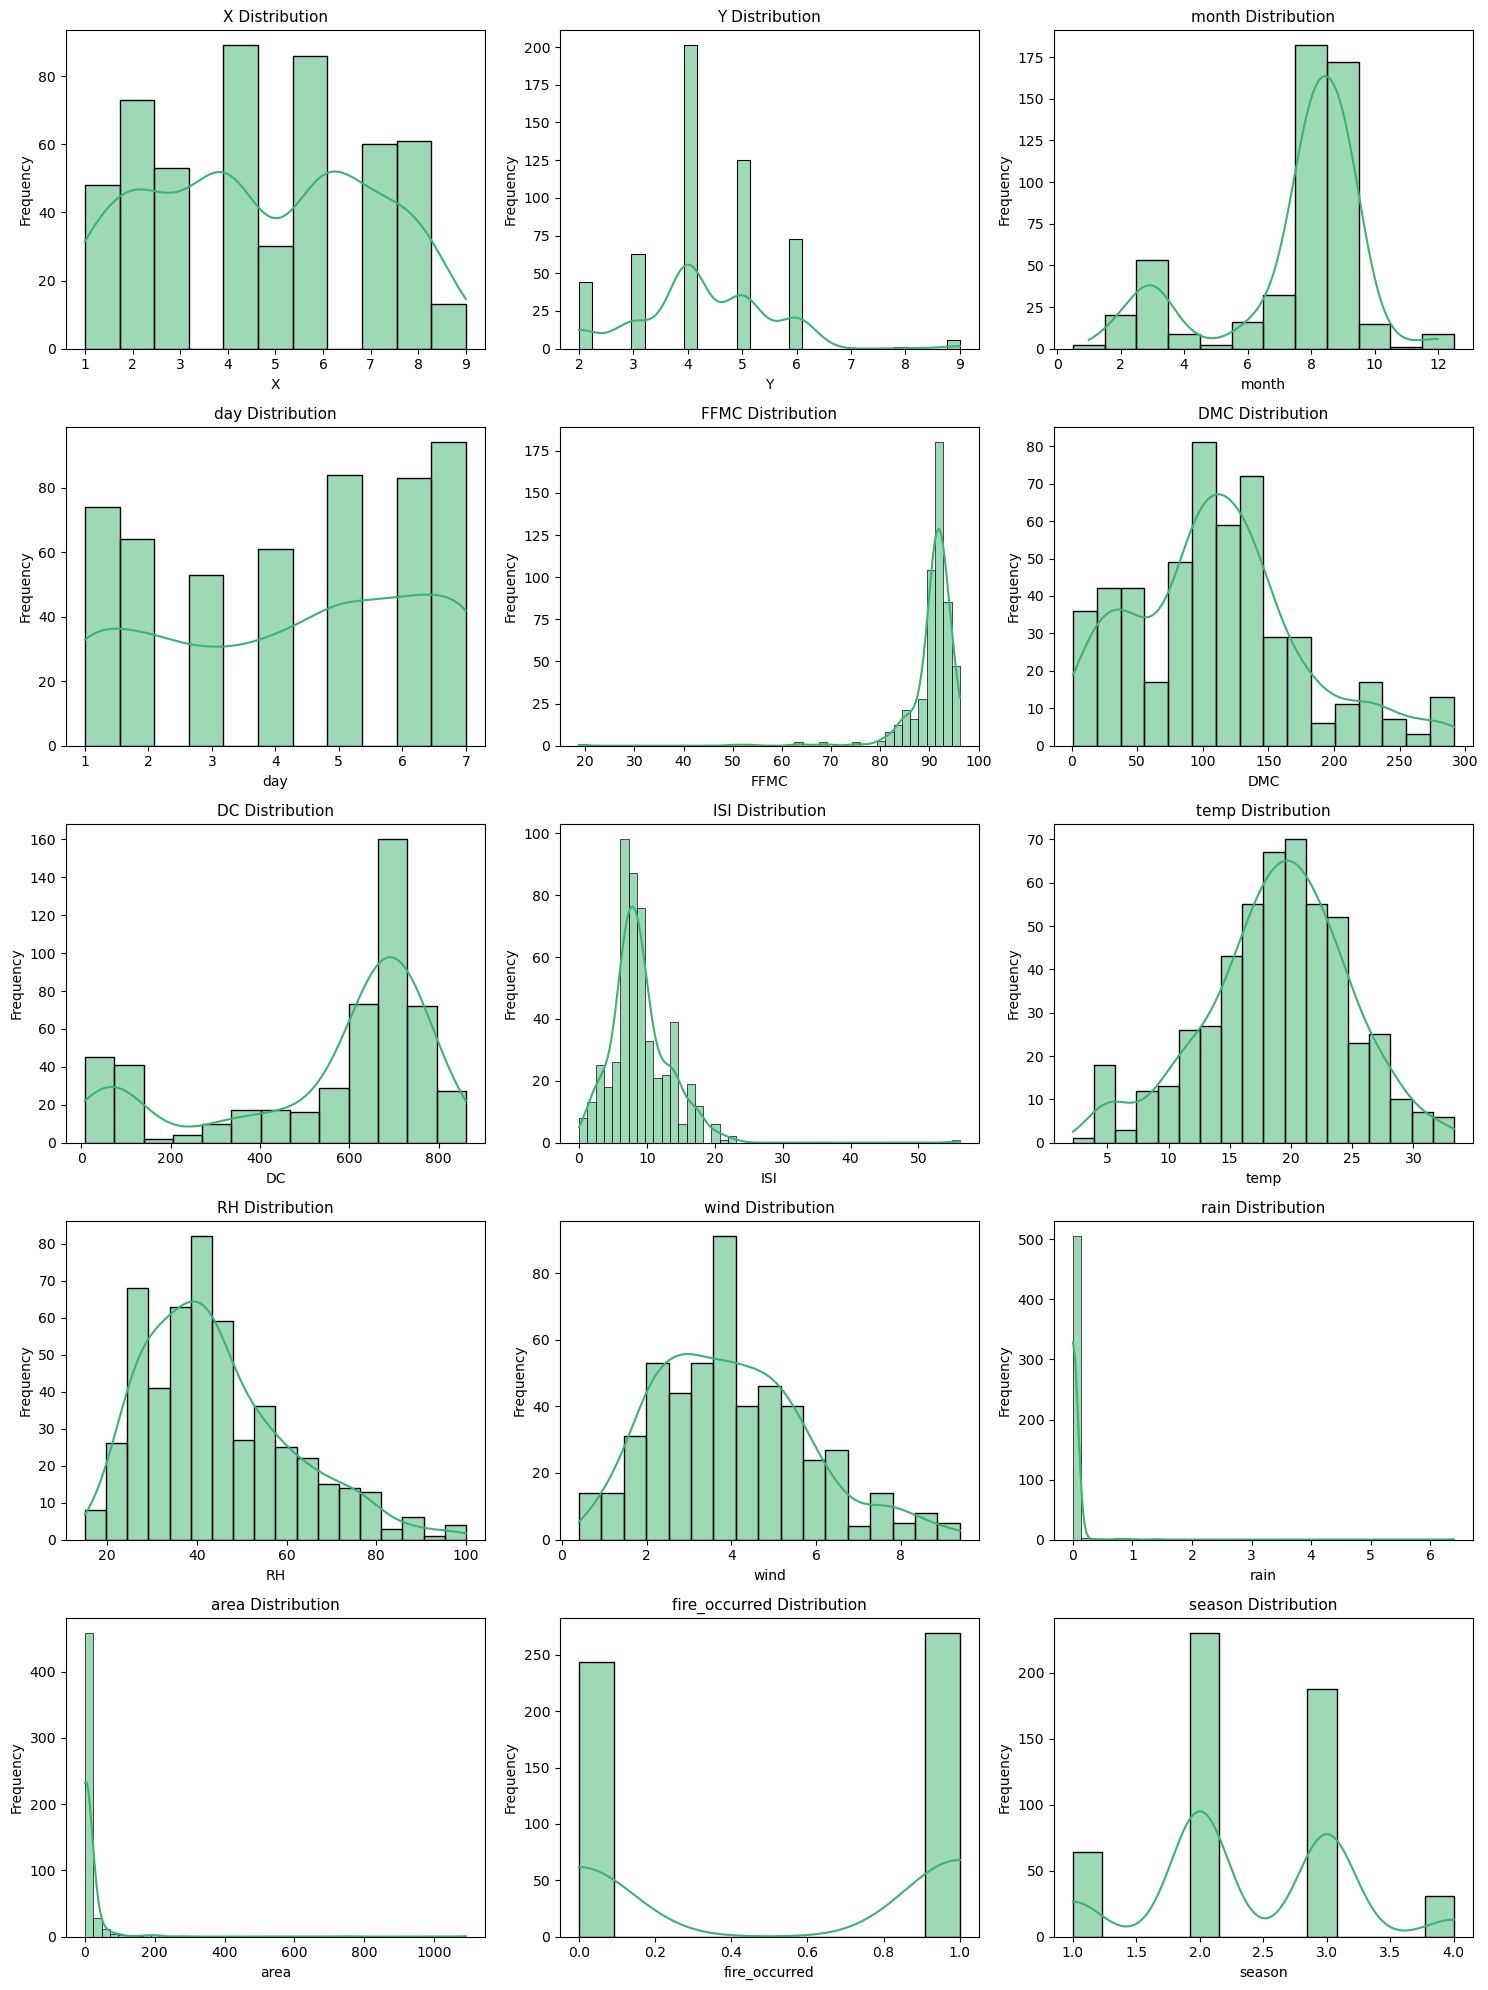

In [63]:

variables = df.columns #all columns in the dataset is used for distribution plotting
cols = 3  #sets the number of plots per row for the figure layout
rows = math.ceil(len(variables) / cols) #calculates the now of rows needed for the figure layout

plt.figure(figsize=(5*cols, 4*rows)) #sets the figure size based on the total number of rows and columns needed

for i, col in enumerate(variables, 1): #iterates thrugh each column 
    plt.subplot(rows, cols, i) #creates a subplot for each column 
    sns.histplot(df[col], kde=True, color='mediumseagreen', edgecolor='black') 
    plt.title(f'{col} Distribution', fontsize=11) #sets the title for each subplot
    plt.xlabel(col) #sets the x-axis label as the column name for each subplot
    plt.ylabel('Frequency') #sets the y-axis label as the frequency for each subplot 

plt.tight_layout()
plt.show()

#reference: https://www.w3schools.com/c/ref_math_ceil.php
#reference: https://www.w3schools.com/python/ref_func_enumerate.asp
#reference: https://www.statology.org/matplotlib-distribution-plot/

**Calculating FWI**

In [64]:
#following function is used to calculate BUI
def calculate_bui(row):
    dmc = row['DMC']
    dc = row['DC']
    if dmc <= 0.4 * dc:
        return (0.8 * dmc * dc) / (dmc + 0.4 * dc)
    else:
        return dmc - ((1 - (0.8 * dc / (dmc + 0.4 * dc))) * (0.92 + (0.0114 * dmc) ** 1.7))
    
#following function is used to calculate BUI for predicted DMC and DC values    
def calculate_bui_pred(row):
    dmc = row['DMC_pred']
    dc = row['DC_pred']
    if dmc <= 0.4 * dc:
        return (0.8 * dmc * dc) / (dmc + 0.4 * dc)
    else:
        return dmc - ((1 - (0.8 * dc / (dmc + 0.4 * dc))) * (0.92 + (0.0114 * dmc) ** 1.7))    
    
#following function is used to calculate FWI    

def calculate_fwi(isi, bui):
    fD = np.where(
        bui <= 80,
        0.626 * (bui ** 0.809) + 2,
        1000 / (25 + 108.64 * np.exp(-0.023 * bui))
    )
    b = 0.1 * isi * fD
    b_safe = np.clip(b, 1e-6, None) # ensures b is not zero or negative to avoid log(0) or negative log
    fwi = np.where(
        b <= 1.0,
        b,
        np.exp(2.72 * (0.434 * np.log(b_safe)) ** 0.647)
    )
    return fwi

#calculates BUI using the function 
df['BUI'] = df.apply(calculate_bui, axis=1)

#calculates FWI using the function 
df['FWI'] = calculate_fwi(df['ISI'], df['BUI'])
y = df['FWI'] # creates a new column for the target variable FWI

print(df.head()) #confirms the new column have been added 

#reference:https://wikifire.wsl.ch/tiki-index259b.html?page=Fire+weather+index
#reference:https://wikifire.wsl.ch/tiki-index8720.html?page=Buildup+index

   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area  \
0  7  5     3    5  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0   
1  7  4    10    2  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0   
2  7  4    10    6  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0   
3  8  6     3    5  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0   
4  8  6     3    7  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0   

   fire_occurred  season        BUI        FWI  
0              0       1  30.921902  10.293590  
1              0       3  62.529409  18.709734  
2              0       3  75.406720  20.671156  
3              0       1  33.260199  16.736804  
4              0       1  51.150592  21.854667  


**Feature Scaling**

In [65]:
features = df.columns.drop('FWI') #all columns excepts FWI is used as the input features
target = 'FWI' #target variable is set as FWI

X = df[features]
y = df[target]

scaler = StandardScaler()  #standard scaler is used for feature scaling (z-score normalisation)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

print("Summary after feature scaling:") #the statistical summary is displayed after feature scaling
print(X_scaled.describe().round(2))


Summary after feature scaling:
            X       Y   month     day    FFMC     DMC      DC     ISI    temp  \
count  513.00  513.00  513.00  513.00  513.00  513.00  513.00  513.00  513.00   
mean     0.00    0.00    0.00   -0.00   -0.00    0.00    0.00    0.00    0.00   
std      1.00    1.00    1.00    1.00    1.00    1.00    1.00    1.00    1.00   
min     -1.59   -1.87   -2.85   -1.57  -13.00   -1.71   -2.19   -1.97   -2.87   
25%     -0.72   -0.24   -0.21   -1.09   -0.08   -0.66   -0.44   -0.57   -0.58   
50%     -0.29   -0.24    0.23    0.36    0.17   -0.04    0.47   -0.14    0.07   
75%      1.00    0.57    0.67    0.84    0.41    0.49    0.67    0.43    0.67   
max      1.86    3.82    1.99    1.33    1.00    2.81    1.26   10.30    2.48   

           RH    wind    rain    area  fire_occurred  season     BUI  
count  513.00  513.00  513.00  513.00         513.00  513.00  513.00  
mean    -0.00   -0.00    0.00   -0.00           0.00   -0.00   -0.00  
std      1.00    1.00    1

Box plot visualisation 

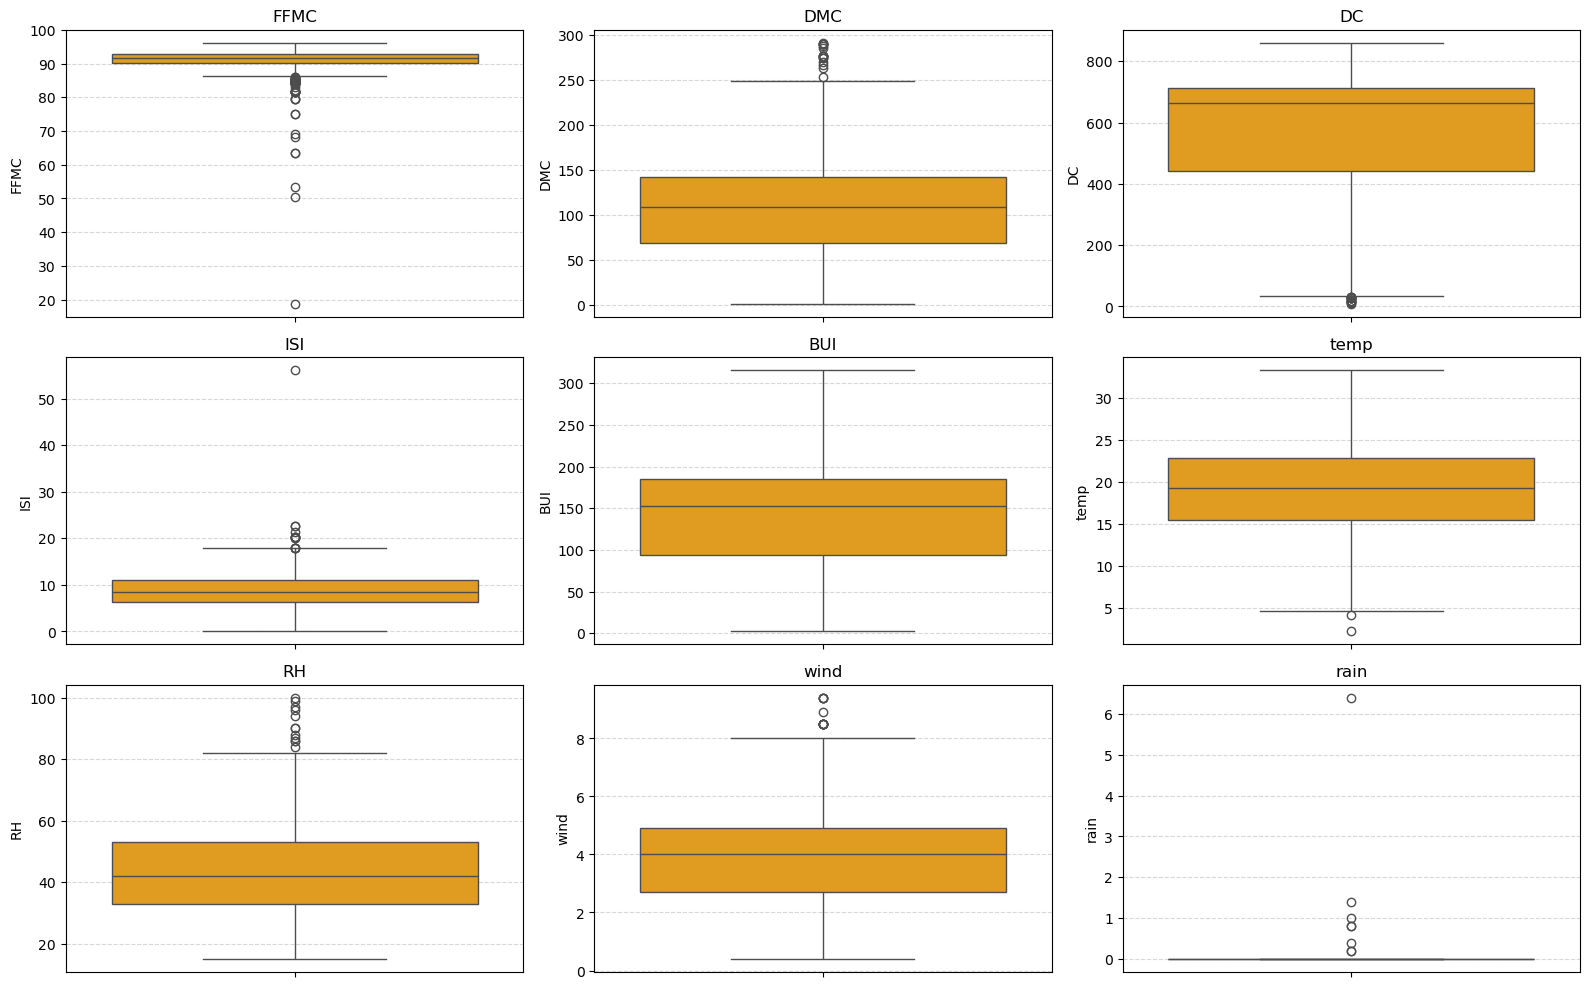

In [66]:

#box plot visualisation of the features after feature scaling
features = ["FFMC", "DMC", "DC", "ISI", "BUI", "temp", "RH", "wind", "rain"] #only the most relevant features are plotted (research is based on weather data and fire indices)

plt.figure(figsize=(16, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)      #creates a subplot for each feature and includes it in a 3 by 3 grid layout
    sns.boxplot(y=df[feature], color="orange")
    plt.title(feature)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
#reference: https://stackoverflow.com/questions/59593943/multiple-boxplots-of-all-categorical-variables-in-one-plotting-window-using-seab

Handling of Outliers

Original dataset size: 513
Dataset size after capping outliers: 513


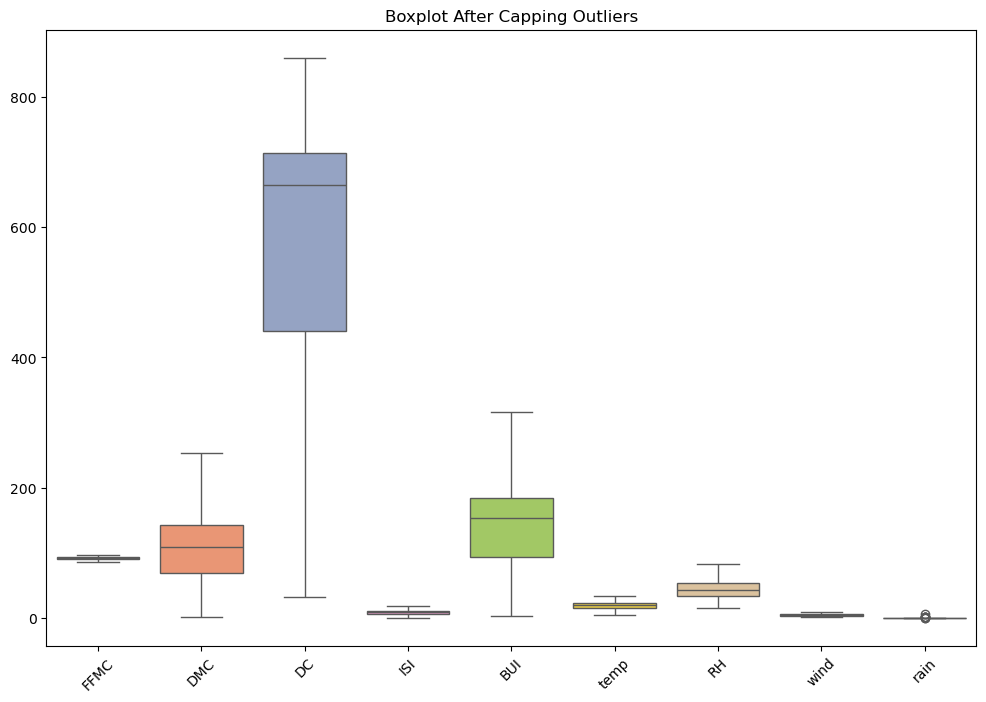

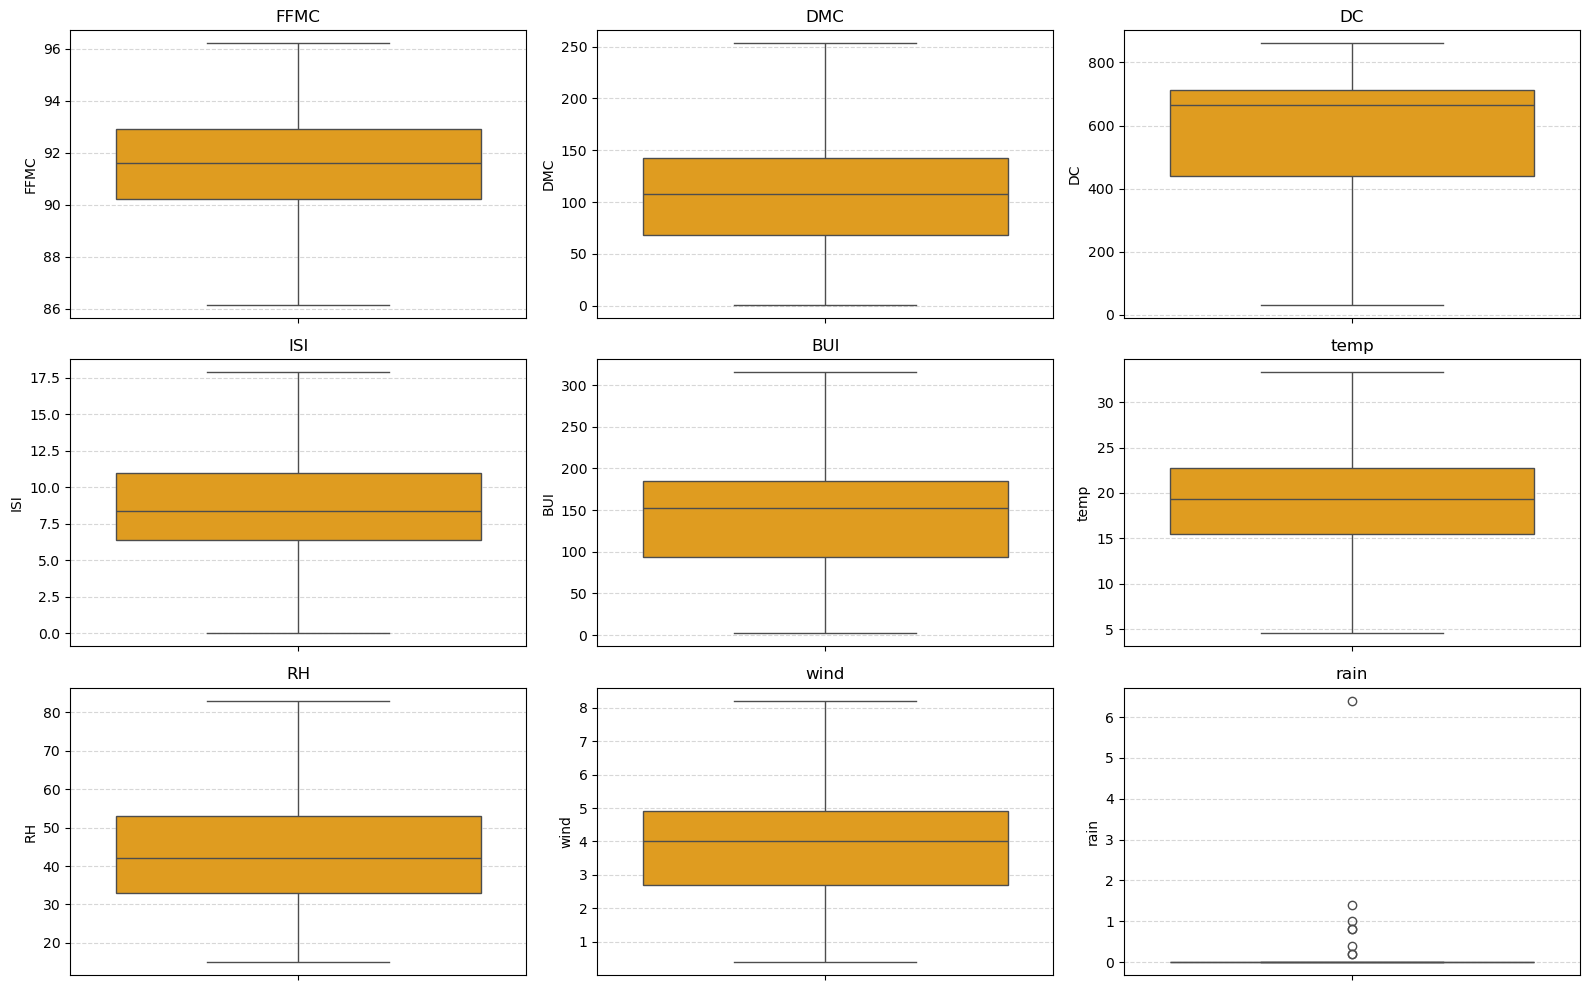

In [67]:

# following fuction is used to limit extreme values using IQR method

def cap_outliers(df, columns, factor=1.5): # k = 1.5 
    df = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        df[col] = np.clip(df[col], lower, upper) #caps/replaces values outside the lower and upper bounds 
    return df

features = ['FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'temp', 'RH', 'wind'] #most relavant features (numerical) for the FWI is used 

df = cap_outliers(df, features) #caps the outliers using the preivously defined function (cap_outliers)

print(f"Original dataset size: {df.shape[0]}")
print(f"Dataset size after capping outliers: {df.shape[0]}")  # prints the size of the dataset after capping outliers to ensure the size is unchanged


scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features +['rain']]) #features scales the capped dataset

#plots boxplots to visualise the capped outliers and ensure no outliers are present
plt.figure(figsize=(12,8))
sns.boxplot(data=df[features+['rain']], palette="Set2")
plt.title("Boxplot After Capping Outliers")
plt.xticks(rotation=45)
plt.show()

# plots individual boxplots for a better visualisation of each feature in a 3 by 3 grid layout (easier to compare with the previous boxplot before capping)
plt.figure(figsize=(16, 10))
for i, feature in enumerate(features+['rain'], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[feature], color="orange")
    plt.title(feature)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
#reference: https://www.geeksforgeeks.org/data-visualization/box-plot-in-python-using-matplotlib/
#reference: https://stackoverflow.com/questions/42207920/how-to-take-floor-and-capping-for-removing-outliers
#reference: https://stackoverflow.com/questions/59593943/multiple-boxplots-of-all-categorical-variables-in-one-plotting-window-using-seab

**Feature Importance**

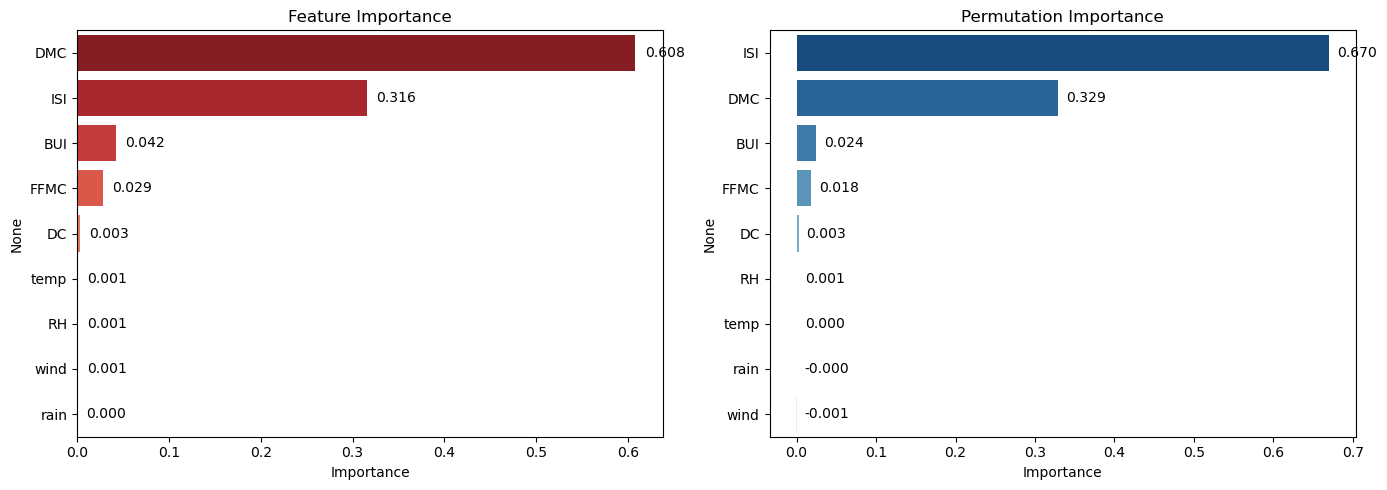

Feature Importance Comparison:
      Built-in  Permutation
BUI      0.042        0.024
DC       0.003        0.003
DMC      0.608        0.329
FFMC     0.029        0.018
ISI      0.316        0.670
RH       0.001        0.001
rain     0.000       -0.000
temp     0.001        0.000
wind     0.001       -0.001


In [ ]:

features = ['FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'temp', 'RH', 'wind', 'rain'] #same most relevant features as before is used 
target = 'FWI'

X = df[features] #capped dataset is used for training the RF model 
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #data is split into 80% training and 20% testing

model = RandomForestRegressor(n_estimators=100, random_state=42) #random forest regressor model is used with 100 trees/estimators 
model.fit(X_train, y_train)

#mdi feature importance and permutation feature importance are calculated
mdi_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False) #built-in feature importance from the random forest model 
perm_result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42) 
perm_importances = pd.Series(perm_result.importances_mean, index=features).sort_values(ascending=False)


fig, axes = plt.subplots(1, 2, figsize=(14, 5))


sns.barplot(x=mdi_importances.values, y=mdi_importances.index, hue=mdi_importances.index, # Plot for MDI - built-in feature importance
            palette='Reds_r', ax=axes[0], legend=False)
axes[0].set_title('Feature Importance')
axes[0].set_xlabel('Importance')

for i, v in enumerate(mdi_importances.values): #values for each bar is added on the barplot
    axes[0].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10)


sns.barplot(x=perm_importances.values, y=perm_importances.index, hue=perm_importances.index, # Plot 2 for the permutation feature importance
            palette='Blues_r', ax=axes[1], legend=False)
axes[1].set_title('Permutation Importance')
axes[1].set_xlabel('Importance')

for i, v in enumerate(perm_importances.values): #values for each bar is added on the barplot
    axes[1].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()


print("Feature Importance Comparison:") #feature comparison table is printed 
print(pd.DataFrame({'Built-in': mdi_importances, 'Permutation': perm_importances}).round(3))

#reference: https://www.geeksforgeeks.org/machine-learning/feature-importance-with-random-forests/ (built-in feature importance)
#reference: https://scikit-learn.org/stable/modules/permutation_importance.html
#reference: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

Pearson Correlation 

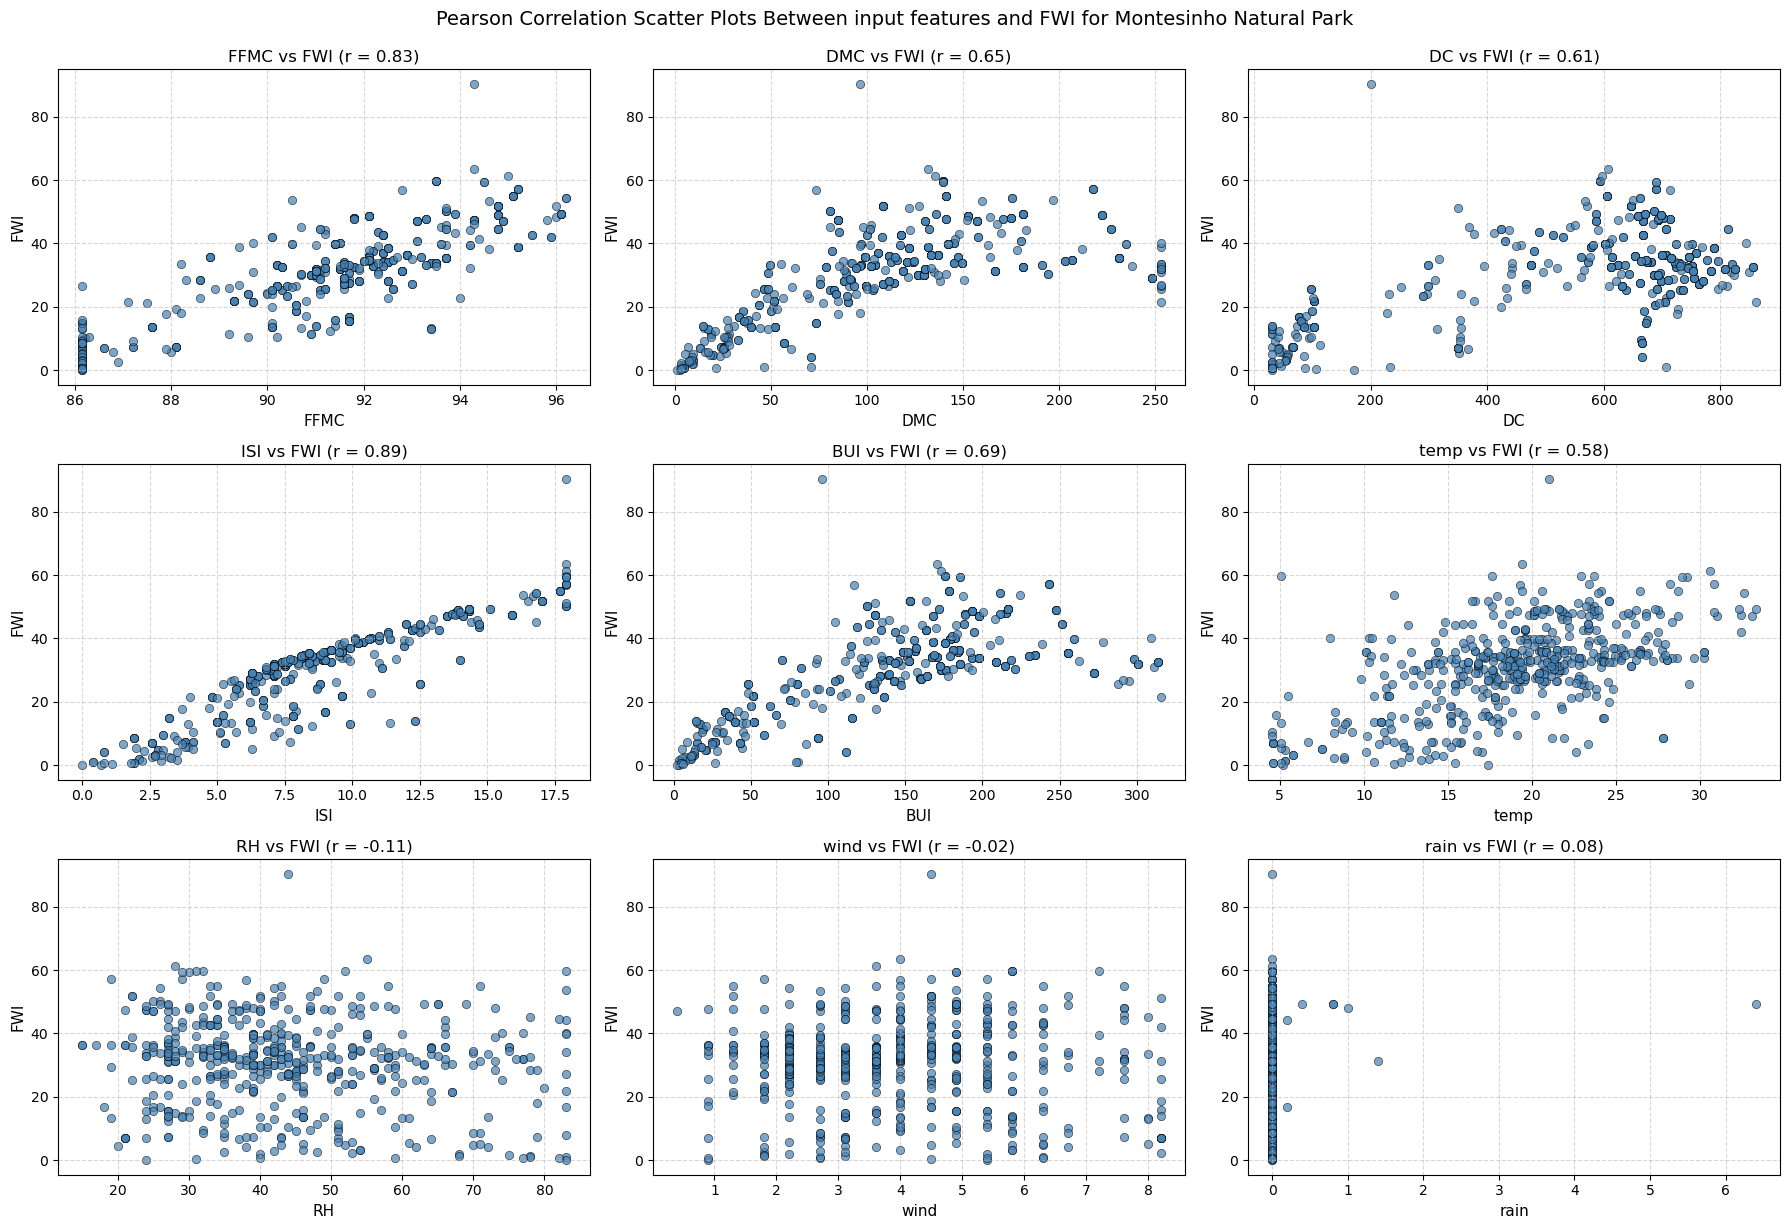

Pearson correlation coefficients for features and FWI:
FFMC: 0.829
DMC: 0.651
DC: 0.609
ISI: 0.891
BUI: 0.690
temp: 0.581
RH: -0.115
wind: -0.023
rain: 0.081


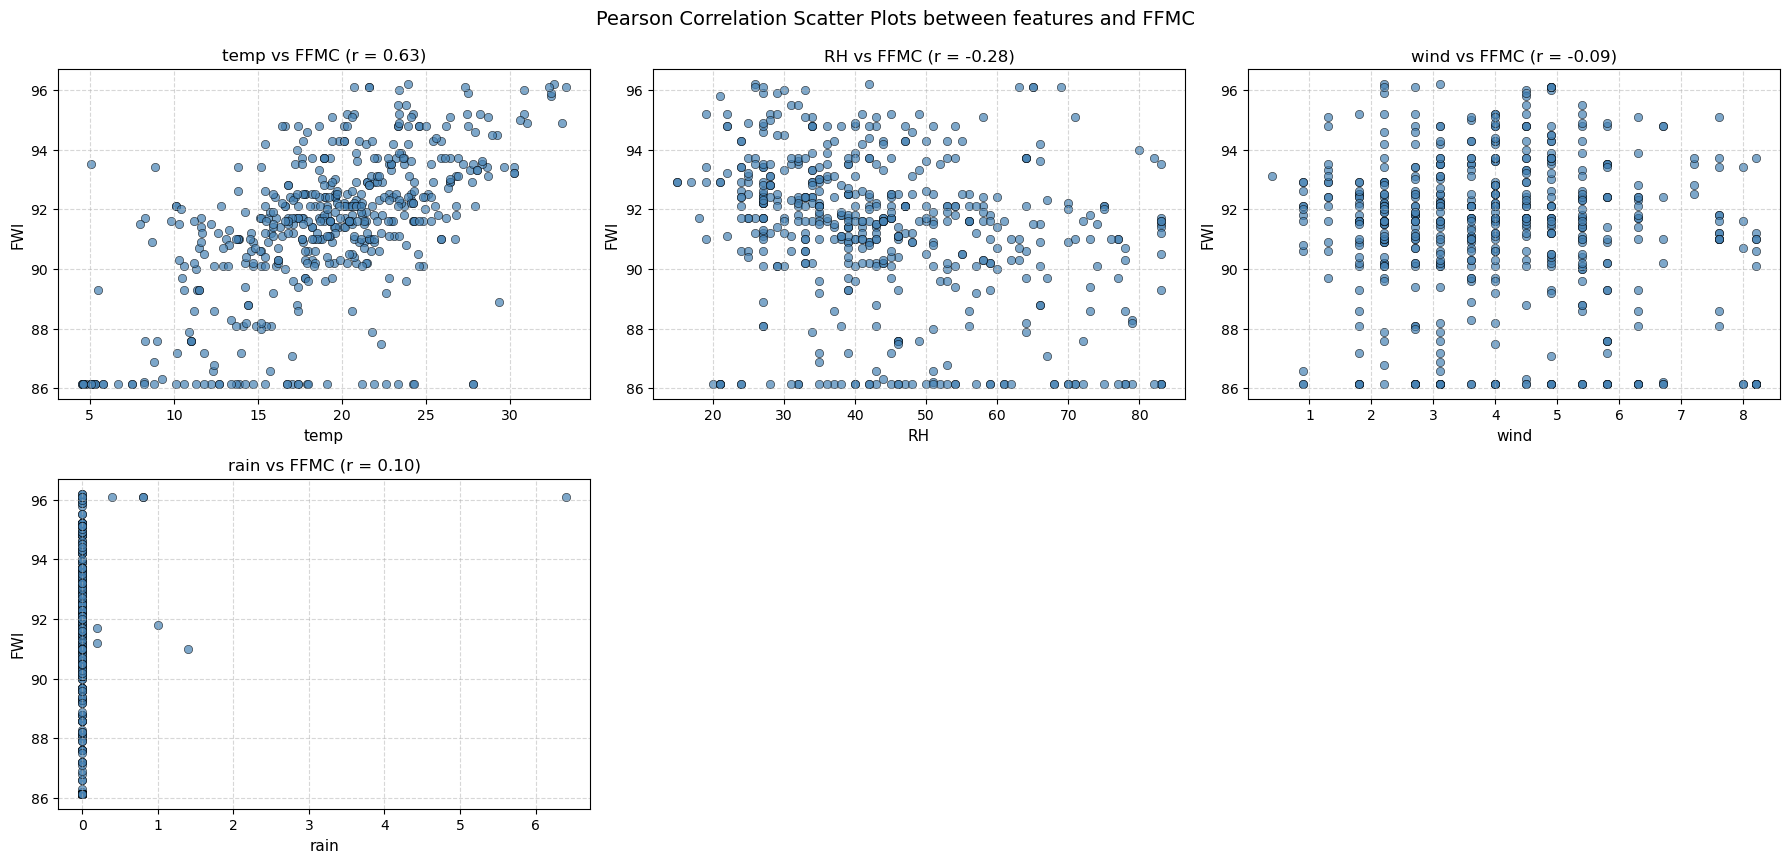

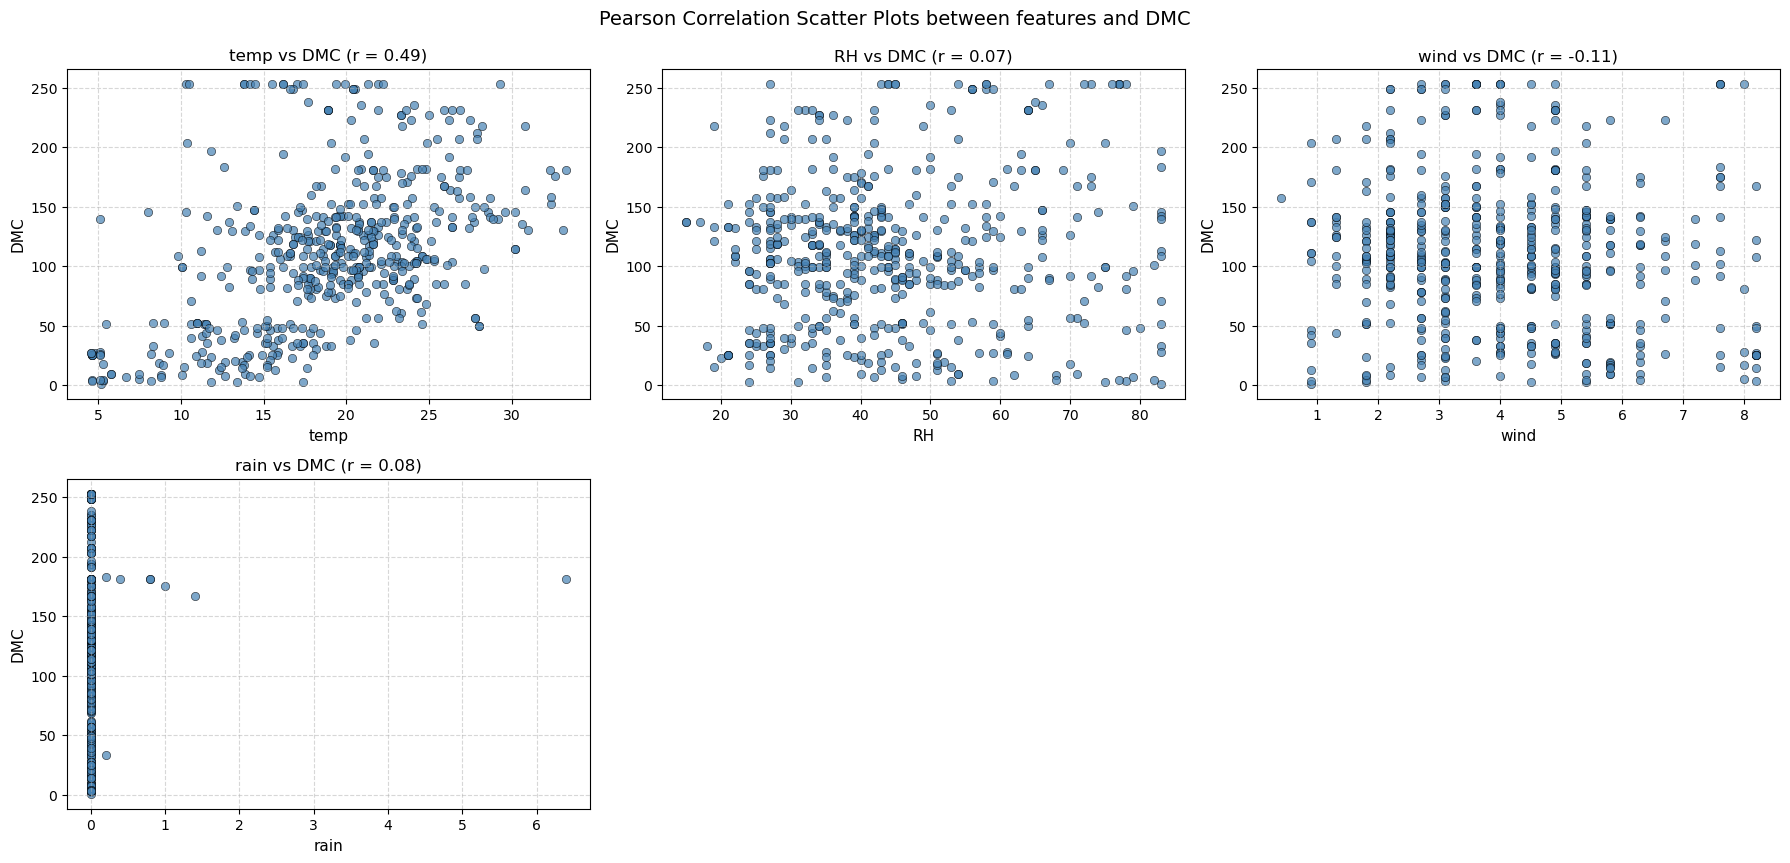

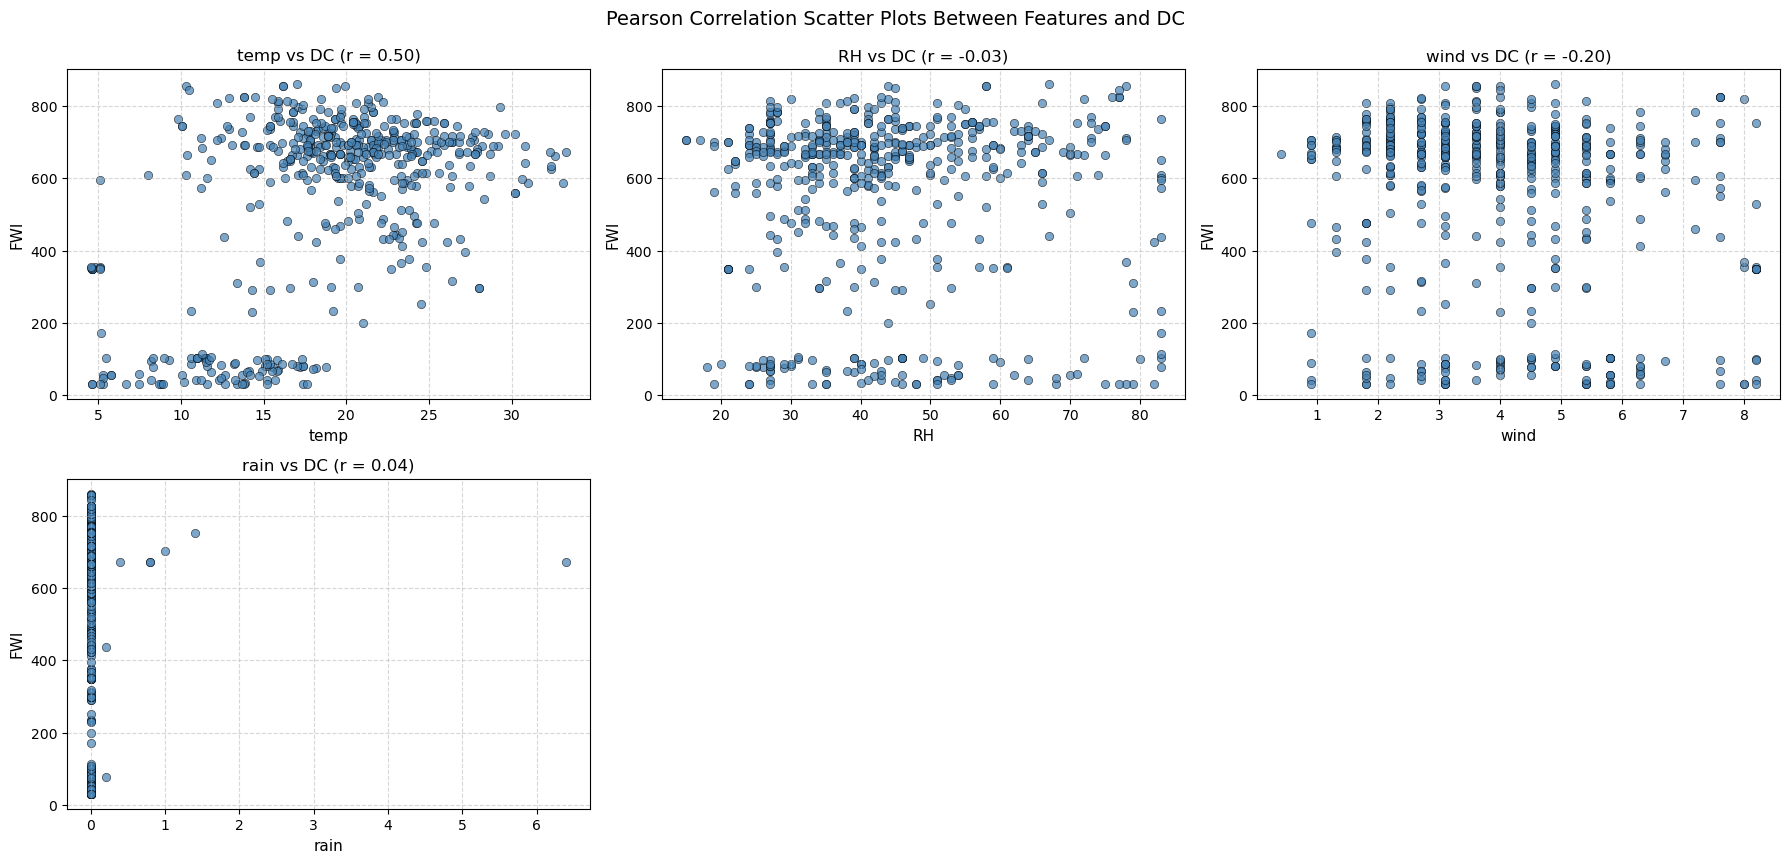

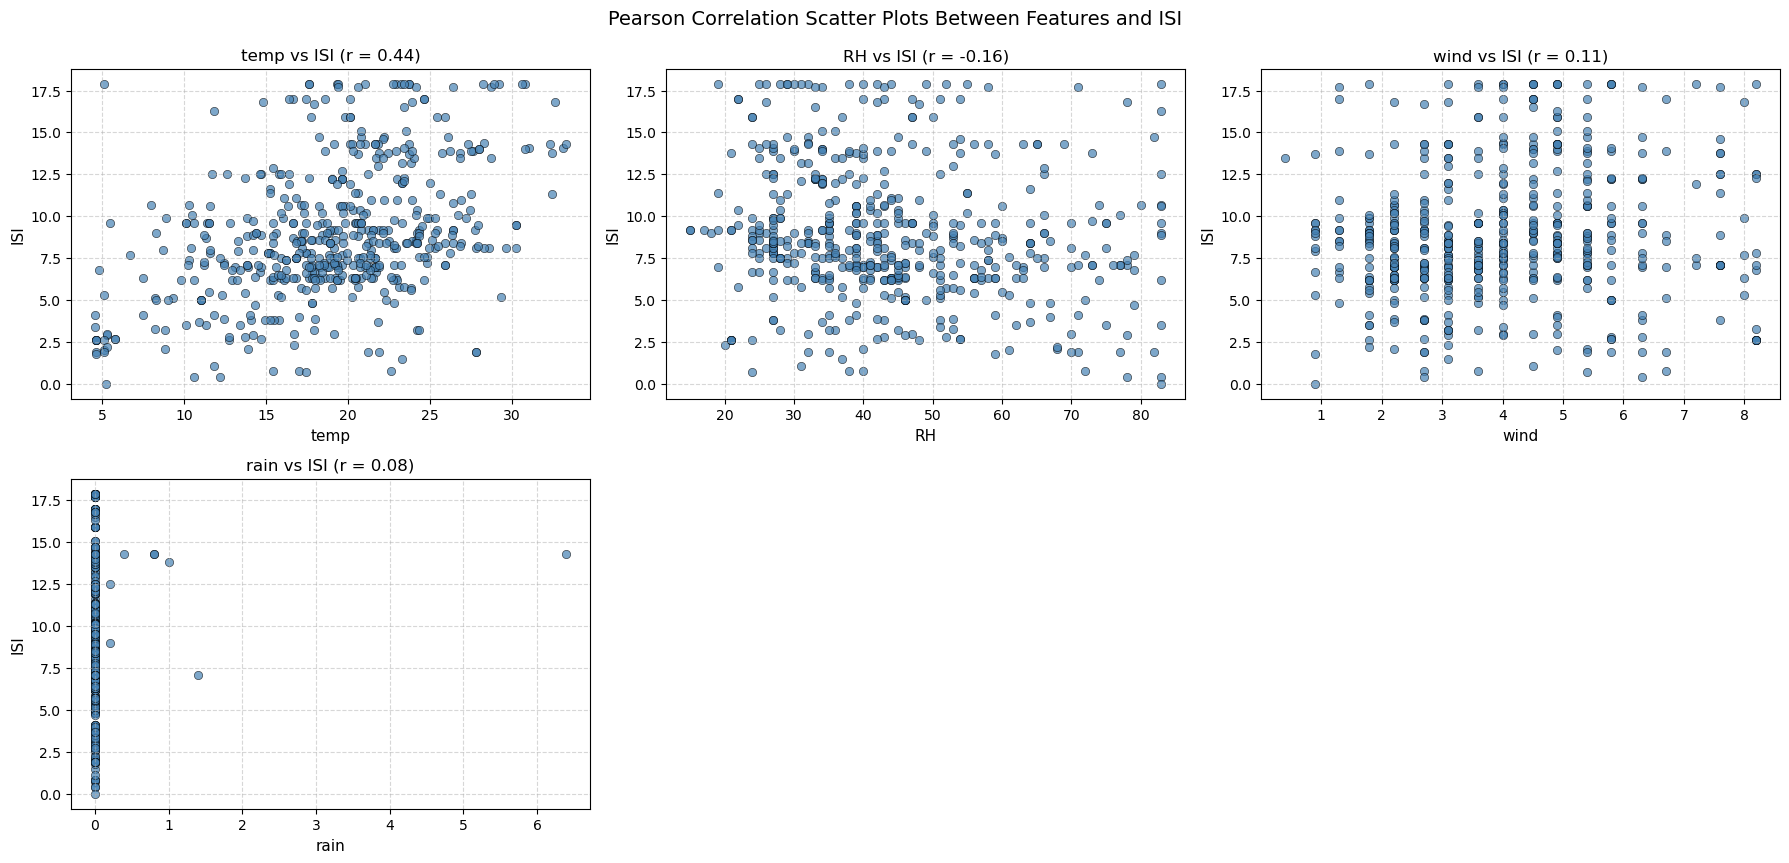

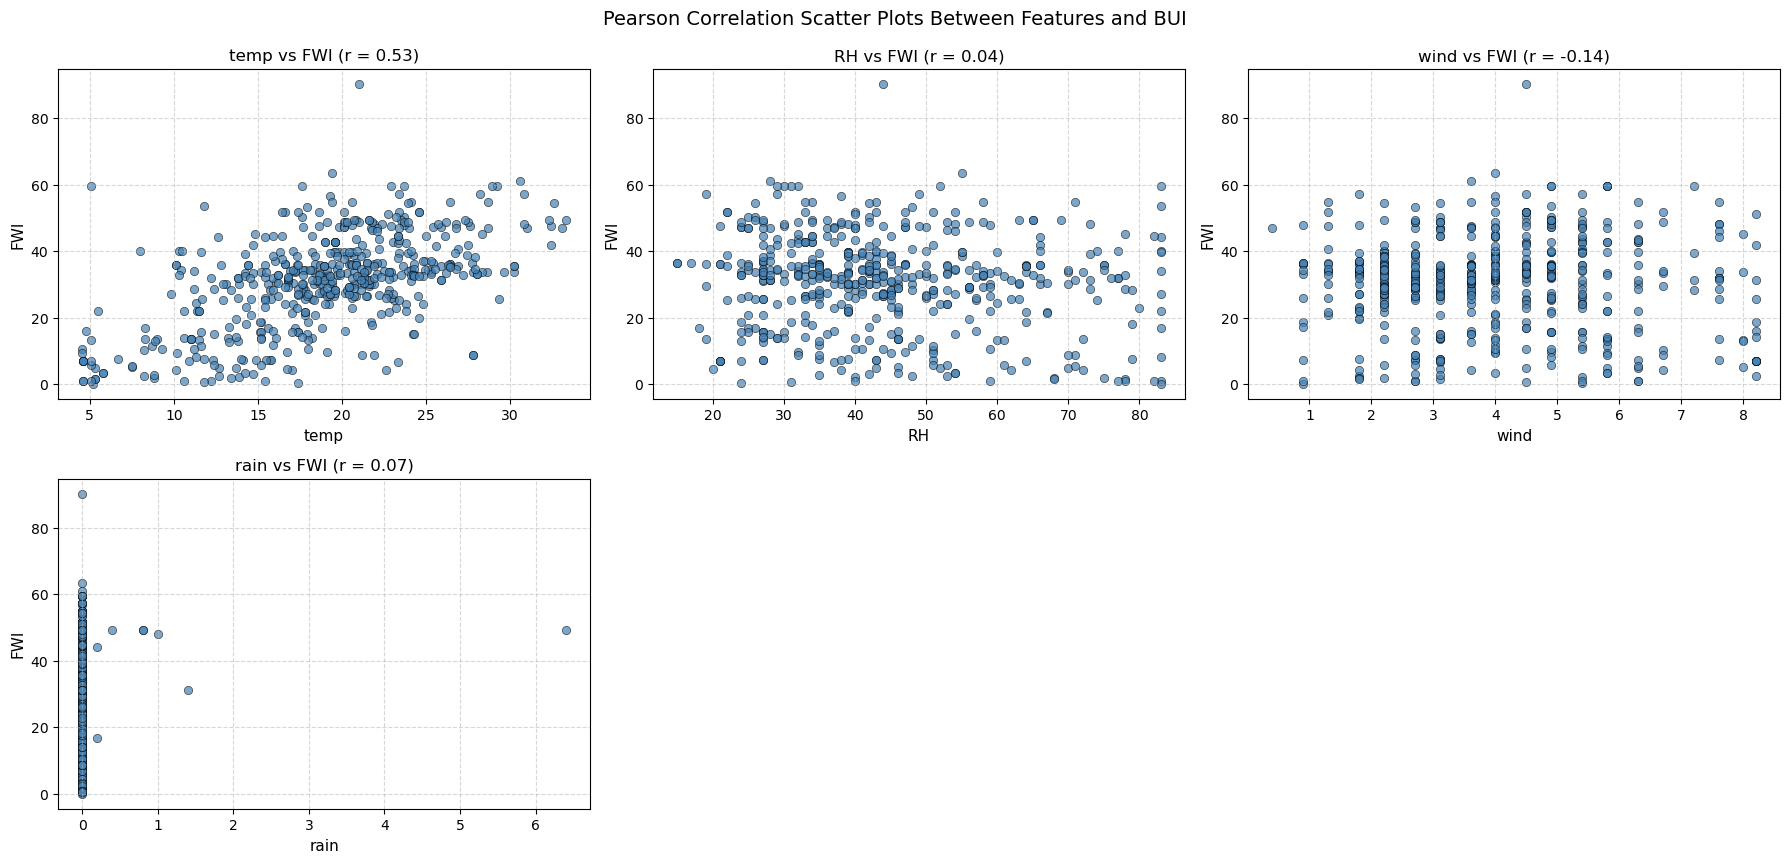

In [ ]:
X = df[features]               
y = df['FWI']         


def covariance(X, y): #calculates the mean differences between the variables
    x_mean = np.mean(X)
    y_mean = np.mean(y)
    return sum((X[i] - x_mean) * (y[i] - y_mean) for i in range(len(X))) / len(X)

def pearson_correlation(X, y): #function to calculate pearson correlation matrix
    cov = covariance(X, y)
    std_dev_x = np.std(X)
    std_dev_y = np.std(y)
    if std_dev_x == 0 or std_dev_y == 0: 
        return np.nan  
    return cov / (std_dev_x * std_dev_y) #divides the calculated value in covariance function by the standard deviation 

plt.figure(figsize=(18, 12))
for i, feature in enumerate(features, 1): #plots the scatter plot
    plt.subplot(3, 3, i)
    sns.scatterplot(
        x=df[feature],
        y=df['FWI'],
        color='steelblue',
        alpha=0.7,
        edgecolor='black'
    )
    
    
    if np.std(df[feature]) == 0 or np.std(df['FWI']) == 0:  #Calculates correlation for each feature
        r = np.nan
    else:
        r = np.corrcoef(df[feature], df['FWI'])[0, 1]

    plt.title(f'{feature} vs FWI (r = {r:.2f})', fontsize=12)
    plt.xlabel(feature, fontsize=11)
    plt.ylabel('FWI', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Pearson Correlation Scatter Plots Between input features and FWI for Montesinho Natural Park", fontsize=14, y=1.02)
plt.show()

correlations = {}
for col in X.columns:
    correlations[col] = pearson_correlation(X[col].values, y.values)

print("Pearson correlation coefficients for features and FWI:")
for feature, r in correlations.items():
    print(f"{feature}: {r:.3f}")


features = ['temp', 'RH', 'wind', 'rain'] #Pearson correlation for FFMC
X = df[features]               
y = df['FFMC']

plt.figure(figsize=(18, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(
        x=df[feature],
        y=df['FFMC'],
        color='steelblue',
        alpha=0.7,
        edgecolor='black'
    )
    
    
    if np.std(df[feature]) == 0 or np.std(df['FFMC']) == 0: # Calculates correlation for each feature
        r = np.nan
    else:
        r = np.corrcoef(df[feature], df['FFMC'])[0, 1]

    plt.title(f'{feature} vs FFMC (r = {r:.2f})', fontsize=12)
    plt.xlabel(feature, fontsize=11)
    plt.ylabel('FWI', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Pearson Correlation Scatter Plots between features and FFMC", fontsize=14, y=1.02)
plt.show()

#Pearson correlation for DMC
features = ['temp', 'RH', 'wind', 'rain']
X = df[features]               
y = df['DMC']

plt.figure(figsize=(18, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(
        x=df[feature],
        y=df['DMC'],
        color='steelblue',
        alpha=0.7,
        edgecolor='black'
    )
    
    
    if np.std(df[feature]) == 0 or np.std(df['DMC']) == 0: # Calculates correlation for each feature
        r = np.nan
    else:
        r = np.corrcoef(df[feature], df['DMC'])[0, 1]

    plt.title(f'{feature} vs DMC (r = {r:.2f})', fontsize=12)
    plt.xlabel(feature, fontsize=11)
    plt.ylabel('DMC', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Pearson Correlation Scatter Plots between features and DMC", fontsize=14, y=1.02)
plt.show()

#pearson correlation for DC
features = ['temp', 'RH', 'wind', 'rain'] 
X = df[features]               
y = df['DC']

plt.figure(figsize=(18, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(
        x=df[feature],
        y=df['DC'],
        color='steelblue',
        alpha=0.7,
        edgecolor='black'
    )
    
    # Calculates correlation for each feature
    if np.std(df[feature]) == 0 or np.std(df['DC']) == 0: 
        r = np.nan
    else:
        r = np.corrcoef(df[feature], df['DC'])[0, 1]

    plt.title(f'{feature} vs DC (r = {r:.2f})', fontsize=12)
    plt.xlabel(feature, fontsize=11)
    plt.ylabel('FWI', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Pearson Correlation Scatter Plots Between Features and DC", fontsize=14, y=1.02)
plt.show()

#pearson correlation for ISI
features = ['temp', 'RH', 'wind', 'rain']
X = df[features]               
y = df['ISI']

plt.figure(figsize=(18, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(
        x=df[feature],
        y=df['ISI'],
        color='steelblue',
        alpha=0.7,
        edgecolor='black'
    )
    
    # Calculates correlation for each feature
    if np.std(df[feature]) == 0 or np.std(df['ISI']) == 0:
        r = np.nan
    else:
        r = np.corrcoef(df[feature], df['ISI'])[0, 1]

    plt.title(f'{feature} vs ISI (r = {r:.2f})', fontsize=12)
    plt.xlabel(feature, fontsize=11)
    plt.ylabel('ISI', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Pearson Correlation Scatter Plots Between Features and ISI", fontsize=14, y=1.02)
plt.show()

#pearson correlation for BUI
features = ['temp', 'RH', 'wind', 'rain']
X = df[features]               
y = df['BUI']

plt.figure(figsize=(18, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(
        x=df[feature],
        y=df['FWI'],
        color='steelblue',
        alpha=0.7,
        edgecolor='black'
    )
    
    if np.std(df[feature]) == 0 or np.std(df['BUI']) == 0:  # Calculates correlation for each feature
        r = np.nan
    else:
        r = np.corrcoef(df[feature], df['BUI'])[0, 1]

    plt.title(f'{feature} vs FWI (r = {r:.2f})', fontsize=12)
    plt.xlabel(feature, fontsize=11)
    plt.ylabel('FWI', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Pearson Correlation Scatter Plots Between Features and BUI", fontsize=14, y=1.02)
plt.show()

#reference: https://medium.com/@shivogojohn/pearson-correlation-coefficient-in-python-74fb569f2b7f

**Model Development**

Model 1 - using all input features 

With Hyperparameter tuning (Optuna)

[I 2025-11-04 21:58:56,181] A new study created in memory with name: no-name-3a142d66-4674-4800-9b55-a6b4b786b4bf


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-04 21:58:56,276] Trial 0 finished with value: 1.7716533728156334 and parameters: {'learning_rate': 0.1330940657381139, 'max_depth': 7, 'subsample': 0.7553158247521827, 'colsample_bytree': 0.5235407211687091, 'lambda': 2.008172428706494, 'alpha': 0.8858466449178519}. Best is trial 0 with value: 1.7716533728156334.
[I 2025-11-04 21:58:56,328] Trial 1 finished with value: 1.6251169473081695 and parameters: {'learning_rate': 0.07827593404564485, 'max_depth': 5, 'subsample': 0.7349532096599369, 'colsample_bytree': 0.5251413914037371, 'lambda': 2.6048825957337582, 'alpha': 0.9274592709952836}. Best is trial 1 with value: 1.6251169473081695.
[I 2025-11-04 21:58:56,370] Trial 2 finished with value: 0.9679908628246153 and parameters: {'learning_rate': 0.18644797907395783, 'max_depth': 3, 'subsample': 0.8429474311236317, 'colsample_bytree': 0.8983506430342698, 'lambda': 0.004326583267144849, 'alpha': 4.823664074531532}. Best is trial 2 with value: 0.9679908628246153.
[I 2025-11-04 21:

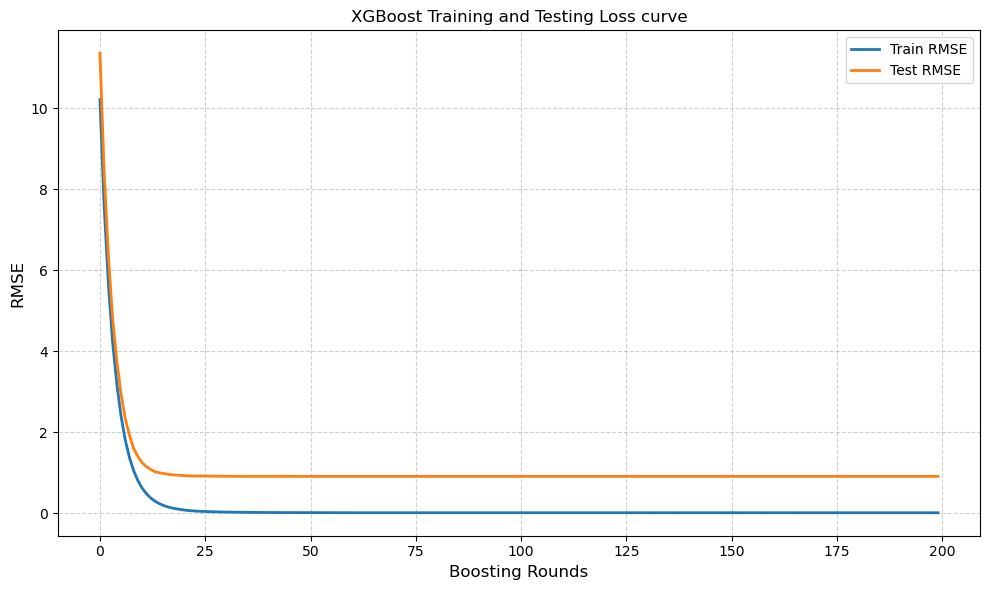

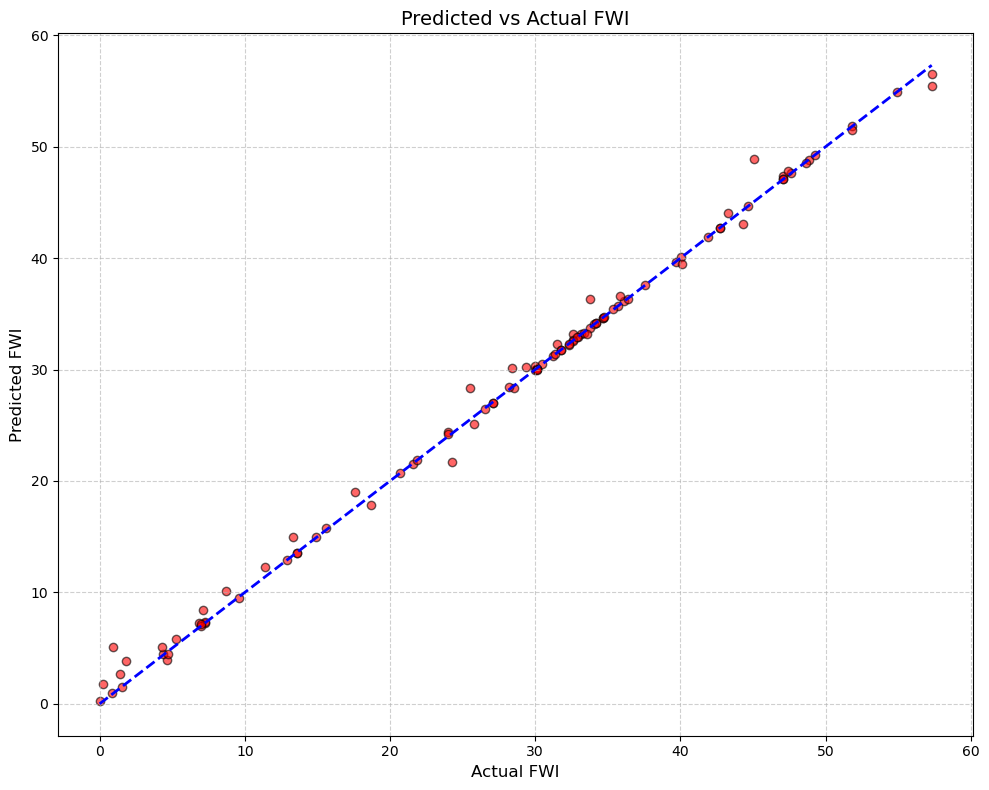

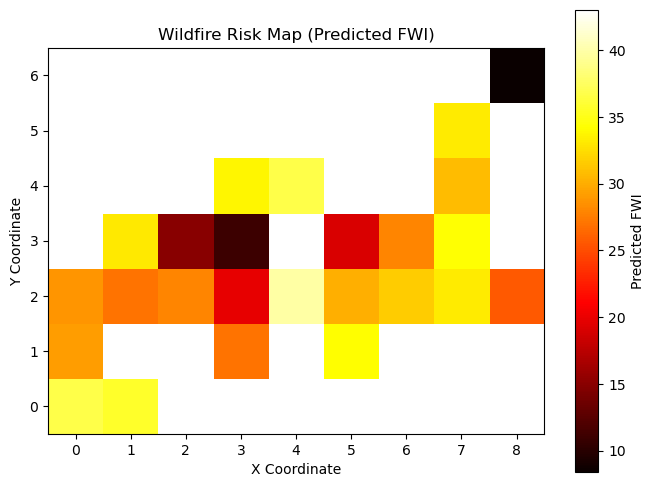

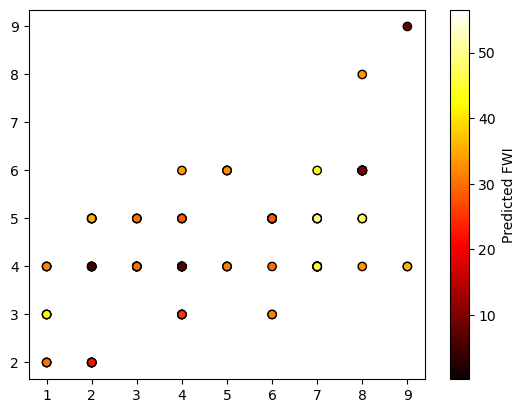

In [ ]:

features = ['temp', 'RH', 'wind', 'rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', "day", "X", "Y"]
target = 'FWI'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

xgb_train = xgb.DMatrix(X_train, y_train)
xgb_test = xgb.DMatrix(X_test, y_test)


def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-8, 5),
        "alpha": trial.suggest_float("alpha", 1e-8, 5),
        "seed": 42
    }
    
    model = xgb.train(params=params, dtrain=xgb_train, num_boost_round=100,
                      evals=[(xgb_test, 'test')],
                      verbose_eval=False)
    
    preds = model.predict(xgb_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, show_progress_bar=True)
best_params = study.best_params.copy()
best_params['objective'] = 'reg:squarederror'
best_params['seed'] = 42
print ("Best hyperparameters:", best_params)

#loss curve plotting
evals_result = {}
final_model = xgb.train(
    params=best_params,
    dtrain=xgb_train,
    num_boost_round=200,
    evals=[(xgb_train, 'train'), (xgb_test, 'test')],
    evals_result=evals_result,
    verbose_eval=False
)

preds = final_model.predict(xgb_test)
r2 = r2_score(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = np.mean(np.abs((y_test - preds)))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

train_rmse_val = evals_result['train']['rmse']
test_rmse_val = evals_result['test']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(train_rmse_val, label='Train RMSE', linewidth=2)
plt.plot(test_rmse_val, label='Test RMSE', linewidth=2)
plt.xlabel('Boosting Rounds', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('XGBoost Training and Testing Loss curve', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(y_test, preds, color='red', alpha=0.6, edgecolor='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'b--', linewidth=2) 
plt.xlabel("Actual FWI", fontsize=12)
plt.ylabel("Predicted FWI", fontsize=12)
plt.title("Predicted vs Actual FWI", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show() 



#reference: https://www.geeksforgeeks.org/machine-learning/implementation-of-xgboost-extreme-gradient-boosting/
#reference: https://xgboost.readthedocs.io/en/stable/python/examples/evals_result.html
#reference: hhttps://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/ttps://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/   (to confirm the shape of the learning curve)
#reference: https://github.com/ishandandekar/misc/blob/8711f9bcd8866ed3f220b2bf3f647993c6884283/xgboost_optuna.py#L15-L17

Same model without hyperparameter tuning

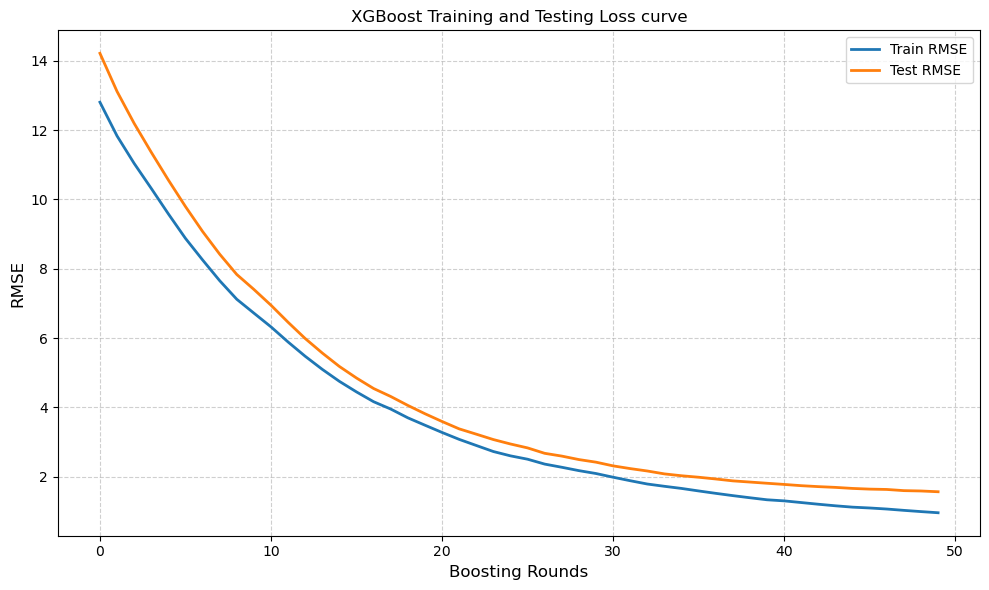

R² Score: 0.989
RMSE: 1.563
MAE: 0.780


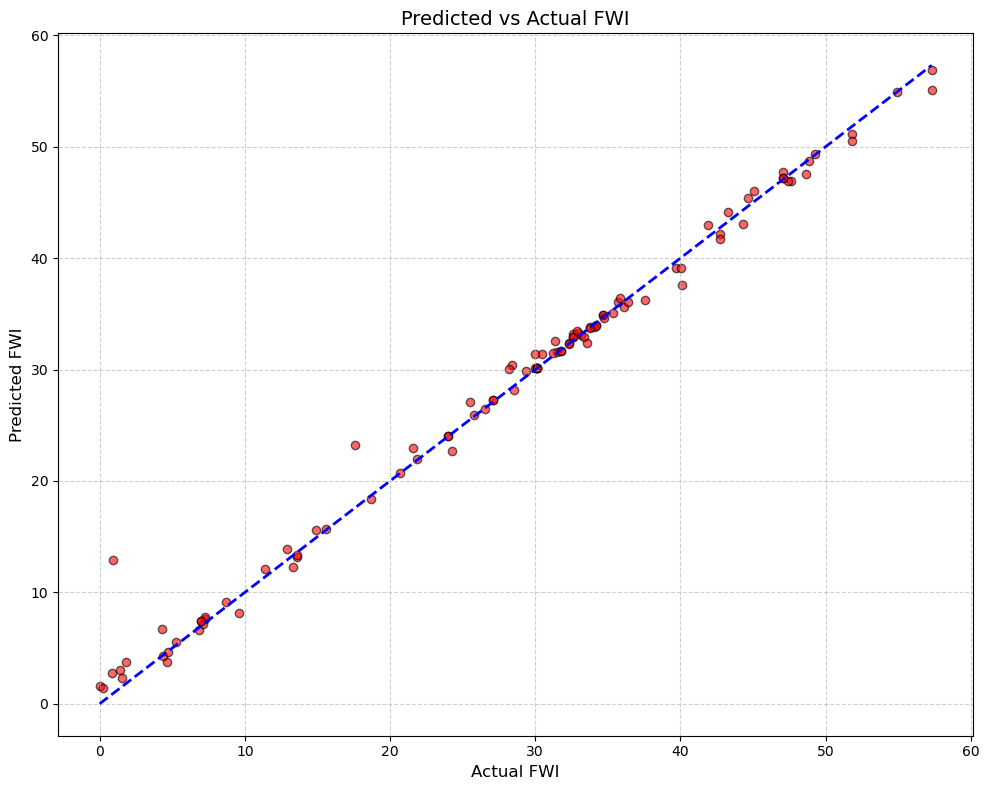

In [ ]:

features = ['temp', 'RH', 'wind', 'rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI'] #input features 
target = 'FWI' #target variable 

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0) #splits the dataset to 80% training and 20% testing 


xgb_train = xgb.DMatrix(X_train, y_train) #converts the inputs to a DMatrix object 
xgb_test = xgb.DMatrix(X_test, y_test)

params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.0835,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1,
    "alpha": 0.1,
    "seed": 42
}
n=50

evals_result = {}

model = xgb.train(params=params,dtrain=xgb_train,num_boost_round=n, evals=[(xgb_train, 'train'), (xgb_test, 'test')],evals_result=evals_result, verbose_eval=False)

train_rmse_val = evals_result['train']['rmse'] 
test_rmse_val = evals_result['test']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(train_rmse_val, label='Train RMSE', linewidth=2)
plt.plot(test_rmse_val, label='Test RMSE', linewidth=2)
plt.xlabel('Boosting Rounds', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('XGBoost Training and Testing Loss curve', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

preds = model.predict(xgb_test)  
r2 = r2_score(y_test, preds)     #calculates the r2 value
rmse = np.sqrt(mean_squared_error(y_test, preds)) #calculates the RMSE value
mae = np.mean(np.abs((y_test - preds))) #calculates the mean absolute error

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

plt.figure(figsize=(10, 8))
plt.scatter(y_test, preds, color='red', alpha=0.6, edgecolor='black') #losss curve is plotted
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'b--', linewidth=2) 
plt.xlabel("Actual FWI", fontsize=12)
plt.ylabel("Predicted FWI", fontsize=12)
plt.title("Predicted vs Actual FWI", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()





**Model 2 - Only weather data**

1) XGBoost

In [ ]:


features = ['temp', 'RH', 'wind', 'rain', 'area', 'day', 'Y', 'X'] #input features used
target = 'FWI' #target variable

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0) #splits the dataset to 80% training and 20% testing 

xgb_train = xgb.DMatrix(X_train, y_train) #converts the inputs to a DMatrix object 
xgb_test = xgb.DMatrix(X_test, y_test)


def objective(trial): #the hyperparameter tuning objective function is defined 
    params = {
        "objective": "reg:squarederror",
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-8, 5),
        "alpha": trial.suggest_float("alpha", 1e-8, 5),
        "seed": 42
    }
    
    model = xgb.train(params=params, dtrain=xgb_train, num_boost_round=100, #model is trained using the intially defined parameters
                      evals=[(xgb_test, 'test')],
                      verbose_eval=True)
    
    preds = model.predict(xgb_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000, show_progress_bar=True)
best_params = study.best_params.copy()
best_params['objective'] = 'reg:squarederror'
best_params['seed'] = 42
print ("Best hyperparameters:", best_params)  #using optuna the best parameters are found 

#loss curve plotting
evals_result = {}
final_model = xgb.train(   #the final model is trained on the best parameters
    params=best_params,
    dtrain=xgb_train,
    num_boost_round=1000,
    evals=[(xgb_train, 'train'), (xgb_test, 'test')],
    evals_result=evals_result,
    verbose_eval=True
)

preds = final_model.predict(xgb_test)   
r2 = r2_score(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = np.mean(np.abs((y_test - preds)))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

train_rmse_val = evals_result['train']['rmse']
test_rmse_val = evals_result['test']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(train_rmse_val, label='Train RMSE', linewidth=2)
plt.plot(test_rmse_val, label='Test RMSE', linewidth=2)
plt.xlabel('Boosting Rounds', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('XGBoost Training and Testing Loss curve', fontsize=12) #loss curve is plotted
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(y_test, preds, color='red', alpha=0.6, edgecolor='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'b--', linewidth=2)  #Predicted VS Actual plot is plotted
plt.xlabel("Actual FWI", fontsize=12)
plt.ylabel("Predicted FWI", fontsize=12)
plt.title("Predicted vs Actual FWI", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show() 


df_map = X_test.copy() 

df_map['FWI_pred'] = preds # Pivot table for heatmap
heatmap_data = df_map.pivot_table(index='Y', columns='X', values='FWI_pred', aggfunc='mean')

plt.figure(figsize=(8,6))
plt.imshow(heatmap_data, origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar(label='Predicted FWI')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Wildfire Risk Map (Predicted FWI)')
plt.show()

plt.scatter(df_map['X'], df_map['Y'], c=df_map['FWI_pred'], cmap='hot', edgecolor='k')
plt.colorbar(label='Predicted FWI')
plt.show() 

#reference: https://www.geeksforgeeks.org/machine-learning/implementation-of-xgboost-extreme-gradient-boosting/
#reference: https://xgboost.readthedocs.io/en/stable/python/examples/evals_result.html
#reference: hhttps://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/ttps://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/   (to confirm the shape of the learning curve)
#reference: https://github.com/ishandandekar/misc/blob/8711f9bcd8866ed3f220b2bf3f647993c6884283/xgboost_optuna.py#L15-L17

[I 2025-11-04 21:58:58,586] A new study created in memory with name: no-name-1edac701-577e-4be8-988d-7e4825dbc494


  0%|          | 0/1000 [00:00<?, ?it/s]

[0]	test-rmse:13.86316
[1]	test-rmse:13.37462
[2]	test-rmse:13.30345
[3]	test-rmse:12.90215
[4]	test-rmse:12.55295
[5]	test-rmse:12.54555
[6]	test-rmse:12.32977
[7]	test-rmse:12.20048
[8]	test-rmse:12.12466
[9]	test-rmse:12.09201
[10]	test-rmse:12.03536
[11]	test-rmse:12.05752
[12]	test-rmse:12.06826
[13]	test-rmse:12.02032
[14]	test-rmse:11.99823
[15]	test-rmse:11.85669
[16]	test-rmse:11.87427
[17]	test-rmse:11.89663
[18]	test-rmse:11.93352
[19]	test-rmse:12.00393
[20]	test-rmse:12.04314
[21]	test-rmse:12.04428
[22]	test-rmse:12.06173
[23]	test-rmse:12.03422
[24]	test-rmse:12.09275
[25]	test-rmse:12.07233
[26]	test-rmse:12.04035
[27]	test-rmse:12.02570
[28]	test-rmse:12.03665
[29]	test-rmse:12.05859
[30]	test-rmse:12.08736
[31]	test-rmse:12.06677
[32]	test-rmse:12.09336
[33]	test-rmse:12.07434
[34]	test-rmse:12.07496
[35]	test-rmse:12.07073
[36]	test-rmse:12.06780
[37]	test-rmse:12.08165
[38]	test-rmse:12.08981
[39]	test-rmse:12.13101
[40]	test-rmse:12.12383
[41]	test-rmse:12.11548
[4

KeyboardInterrupt: 

XGBoost Regressor 

[I 2025-11-04 21:35:08,808] A new study created in memory with name: no-name-5cbc1656-269c-451e-8a77-252d6da916d1
[I 2025-11-04 21:35:08,922] Trial 0 finished with value: 12.054642633606287 and parameters: {'n_estimators': 121, 'max_depth': 9, 'learning_rate': 0.05297380352594615, 'subsample': 0.5342699527409487, 'colsample_bytree': 0.74514493713788, 'reg_lambda': 0.5836114117186803, 'reg_alpha': 2.49846193242642}. Best is trial 0 with value: 12.054642633606287.
[I 2025-11-04 21:35:09,127] Trial 1 finished with value: 12.619807060661584 and parameters: {'n_estimators': 506, 'max_depth': 4, 'learning_rate': 0.0024626787329207487, 'subsample': 0.8482750637830285, 'colsample_bytree': 0.6998839571996627, 'reg_lambda': 0.47621520948720764, 'reg_alpha': 0.1301860396240933}. Best is trial 0 with value: 12.054642633606287.
[I 2025-11-04 21:35:09,196] Trial 2 finished with value: 12.117031788484356 and parameters: {'n_estimators': 114, 'max_depth': 5, 'learning_rate': 0.025653418521067176, 'sub

[I 2025-11-04 21:35:10,768] Trial 10 finished with value: 11.837163512303121 and parameters: {'n_estimators': 747, 'max_depth': 7, 'learning_rate': 0.10048206012056021, 'subsample': 0.9947606785449459, 'colsample_bytree': 0.5171224800567904, 'reg_lambda': 1.8213796173577839, 'reg_alpha': 1.2178455541156665}. Best is trial 10 with value: 11.837163512303121.
[I 2025-11-04 21:35:11,038] Trial 11 finished with value: 11.912678007288836 and parameters: {'n_estimators': 696, 'max_depth': 7, 'learning_rate': 0.10742314613605246, 'subsample': 0.998301286715833, 'colsample_bytree': 0.5159735840821409, 'reg_lambda': 1.6424133861952699, 'reg_alpha': 1.2430373442980995}. Best is trial 10 with value: 11.837163512303121.
[I 2025-11-04 21:35:11,273] Trial 12 finished with value: 11.547004473280285 and parameters: {'n_estimators': 727, 'max_depth': 7, 'learning_rate': 0.10207172288832932, 'subsample': 0.9160621877251296, 'colsample_bytree': 0.5148889218418155, 'reg_lambda': 1.6810661825991544, 'reg_al

XGBoost R²: 0.42236620868854413


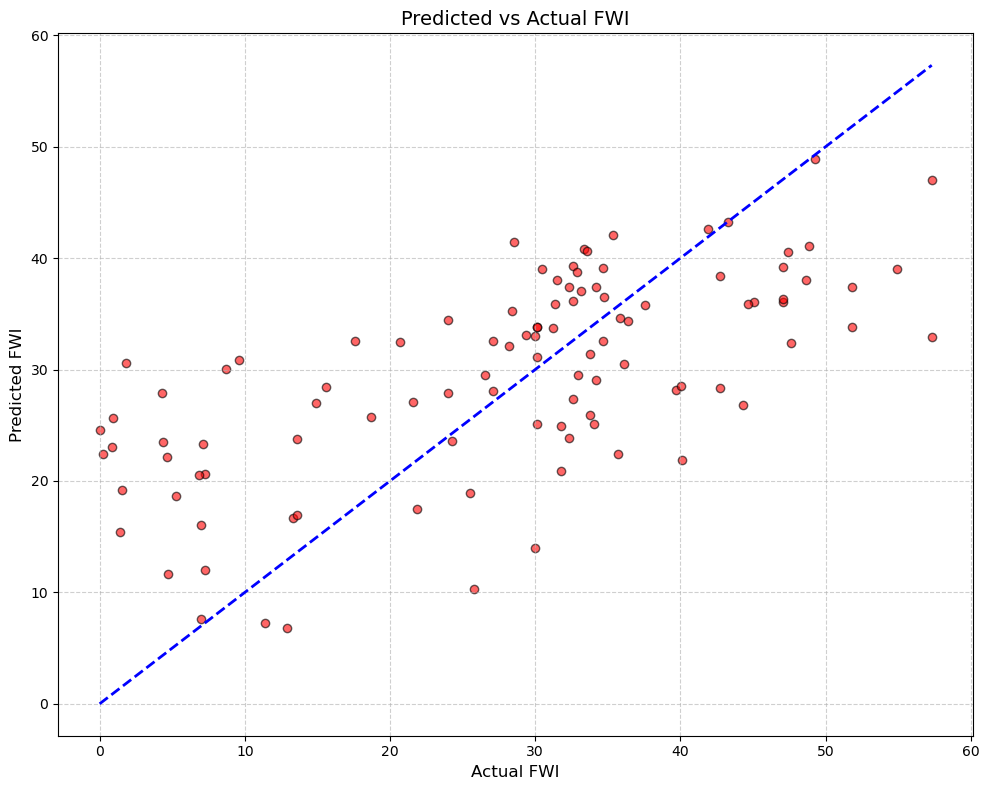

In [ ]:


features = ['temp', 'RH', 'wind', 'rain', 'day', 'area','Y', 'X']
target = 'FWI'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


def xgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 5),
        "random_state": 42
    }
    
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(xgb_objective, n_trials=30)
best_xgb_params = study_xgb.best_params
best_xgb_params['random_state'] = 42

xgb_model = xgb.XGBRegressor(**best_xgb_params)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print("XGBoost R²:", r2_score(y_test, xgb_preds))

plt.figure(figsize=(10, 8))
plt.scatter(y_test, xgb_preds, color='red', alpha=0.6, edgecolor='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'b--', linewidth=2) 
plt.xlabel("Actual FWI", fontsize=12)
plt.ylabel("Predicted FWI", fontsize=12)
plt.title("Predicted vs Actual FWI", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#reference: https://medium.com/@fraidoonomarzai99/xgboost-regression-in-depth-cb2b3f623281

Light GBM

[I 2025-11-04 21:35:17,632] A new study created in memory with name: no-name-a4a0c87d-8b0b-497e-a738-0c28d8970714


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

c:\Users\VICTUS\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\VICTUS\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\VICTUS\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\VICTUS\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:17,906] Trial 2 finished with value: 12.143824331947947 and parameters: {'n_estimators': 524, 'num_leaves': 41, 'max_depth': 9, 'learning_rate': 0.1743969549032079, 'subsample': 0.9336200936670223, 'colsample_bytree': 0.7621778347309197, 'reg_alpha': 1.1308035844224151, 'reg_lambda': 0.7056616678720756}. Best is trial 0 with value: 11.254559808747558.
[I 2025-11-04 21:35:17,953] Trial 3 finished with value: 11.714475676765998 and parameters: {'n_estimators': 222, 'num_leaves': 148, 'max_depth': 10, 'learning_rate': 0.16624787681331984, 'subsample': 0.7519708582935042, 'colsample_bytree': 0.7251840710853837, 'reg_alpha': 4.883499460995378, 'reg_lambda': 0.5336655967983067}. Best is trial 0 with value: 11.254559808747558.
[I 2025-11-04 21:35:18,057] Trial 4 finished with value: 11.959081175875726 and parameters: {'n_estimators': 565, 'num_leaves': 28, 'max_depth': 10, 'learning_rate': 0.237159653601385, 'subsample': 0.6260066147539921, 'colsample_bytree': 0.7511179183

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:18,113] Trial 5 finished with value: 11.275951373428553 and parameters: {'n_estimators': 518, 'num_leaves': 108, 'max_depth': 3, 'learning_rate': 0.1864360567912465, 'subsample': 0.9403463239309072, 'colsample_bytree': 0.6514950544146906, 'reg_alpha': 0.016937876988454836, 'reg_lambda': 2.6606821540062398}. Best is trial 0 with value: 11.254559808747558.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:18,208] Trial 6 finished with value: 11.184345435023493 and parameters: {'n_estimators': 615, 'num_leaves': 62, 'max_depth': 8, 'learning_rate': 0.0651616694568077, 'subsample': 0.6135678977554618, 'colsample_bytree': 0.9518629432628336, 'reg_alpha': 1.7809071380728292, 'reg_lambda': 1.9583668481566219}. Best is trial 6 with value: 11.184345435023493.
[I 2025-11-04 21:35:18,260] Trial 7 finished with value: 11.302054888506904 and parameters: {'n_estimators': 486, 'num_leaves': 47, 'max_depth': 4, 'learning_rate': 0.01656449685520755, 'subsample': 0.6749952029845029, 'colsample_bytree': 0.8651881075387364, 'reg_alpha': 1.1043953394292876, 'reg_lambda': 3.5833081927551493}. Best is trial 6 with value: 11.184345435023493.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:18,355] Trial 8 finished with value: 11.653000309985737 and parameters: {'n_estimators': 489, 'num_leaves': 151, 'max_depth': 13, 'learning_rate': 0.24515603869069696, 'subsample': 0.8180353717746816, 'colsample_bytree': 0.9955015439605652, 'reg_alpha': 2.97745266023381, 'reg_lambda': 4.322305031051567}. Best is trial 6 with value: 11.184345435023493.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:18,512] Trial 9 finished with value: 11.609661248913083 and parameters: {'n_estimators': 839, 'num_leaves': 83, 'max_depth': 6, 'learning_rate': 0.16392402434793962, 'subsample': 0.8521768401568657, 'colsample_bytree': 0.6438222766725278, 'reg_alpha': 3.705307441046232, 'reg_lambda': 2.046117077667841}. Best is trial 6 with value: 11.184345435023493.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:18,692] Trial 10 finished with value: 11.862763413183792 and parameters: {'n_estimators': 971, 'num_leaves': 79, 'max_depth': 15, 'learning_rate': 0.09029486218970055, 'subsample': 0.6049107547534274, 'colsample_bytree': 0.8986500239971817, 'reg_alpha': 2.2689838635611657, 'reg_lambda': 1.261648391283183}. Best is trial 6 with value: 11.184345435023493.
[I 2025-11-04 21:35:18,727] Trial 11 finished with value: 11.310876643907614 and parameters: {'n_estimators': 116, 'num_leaves': 200, 'max_depth': 7, 'learning_rate': 0.04264679022199251, 'subsample': 0.7491275758784006, 'colsample_bytree': 0.9955770929361589, 'reg_alpha': 0.011621292747973466, 'reg_lambda': 1.8477625899723327}. Best is trial 6 with value: 11.184345435023493.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:18,792] Trial 12 finished with value: 11.302398886184122 and parameters: {'n_estimators': 321, 'num_leaves': 198, 'max_depth': 7, 'learning_rate': 0.08043545826191227, 'subsample': 0.8725575335402915, 'colsample_bytree': 0.9108967107473199, 'reg_alpha': 1.9684921854069382, 'reg_lambda': 2.7767240209626056}. Best is trial 6 with value: 11.184345435023493.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:18,942] Trial 13 finished with value: 11.6261837413187 and parameters: {'n_estimators': 689, 'num_leaves': 161, 'max_depth': 8, 'learning_rate': 0.1079453138509916, 'subsample': 0.9976752052478459, 'colsample_bytree': 0.9374149171659479, 'reg_alpha': 1.6741503768337194, 'reg_lambda': 1.5656233218473665}. Best is trial 6 with value: 11.184345435023493.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:19,017] Trial 14 finished with value: 11.198114705113476 and parameters: {'n_estimators': 340, 'num_leaves': 69, 'max_depth': 11, 'learning_rate': 0.040923915619881776, 'subsample': 0.7446355449292518, 'colsample_bytree': 0.8436179116764844, 'reg_alpha': 0.6964313174157164, 'reg_lambda': 0.026645718849032995}. Best is trial 6 with value: 11.184345435023493.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:19,164] Trial 15 finished with value: 11.346600945496899 and parameters: {'n_estimators': 342, 'num_leaves': 72, 'max_depth': 12, 'learning_rate': 0.010757878550665588, 'subsample': 0.7003302471290183, 'colsample_bytree': 0.8401138881020809, 'reg_alpha': 1.5468007941266024, 'reg_lambda': 0.007936884193120382}. Best is trial 6 with value: 11.184345435023493.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:19,431] Trial 16 finished with value: 11.898719072721693 and parameters: {'n_estimators': 657, 'num_leaves': 59, 'max_depth': 12, 'learning_rate': 0.12345922206040283, 'subsample': 0.6508302843836116, 'colsample_bytree': 0.8334563288050284, 'reg_alpha': 0.7061825506965438, 'reg_lambda': 0.9147817568267711}. Best is trial 6 with value: 11.184345435023493.
[I 2025-11-04 21:35:19,504] Trial 17 finished with value: 12.142136238891593 and parameters: {'n_estimators': 359, 'num_leaves': 99, 'max_depth': 11, 'learning_rate': 0.29040855690937306, 'subsample': 0.7285134427073638, 'colsample_bytree': 0.8808659316305012, 'reg_alpha': 2.8263142678206843, 'reg_lambda': 0.16370503676010564}. Best is trial 6 with value: 11.184345435023493.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:19,589] Trial 18 finished with value: 11.27385914427085 and parameters: {'n_estimators': 405, 'num_leaves': 20, 'max_depth': 14, 'learning_rate': 0.05061228858528129, 'subsample': 0.8163515401688078, 'colsample_bytree': 0.7108989682712559, 'reg_alpha': 4.208819410816314, 'reg_lambda': 3.5552448188117487}. Best is trial 6 with value: 11.184345435023493.
[I 2025-11-04 21:35:19,698] Trial 19 finished with value: 11.504725562927458 and parameters: {'n_estimators': 623, 'num_leaves': 58, 'max_depth': 9, 'learning_rate': 0.07846725106604117, 'subsample': 0.6458822339555528, 'colsample_bytree': 0.8163290867706171, 'reg_alpha': 2.3705301594690544, 'reg_lambda': 1.0939188195094316}. Best is trial 6 with value: 11.184345435023493.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:19,854] Trial 20 finished with value: 11.1871774563796 and parameters: {'n_estimators': 743, 'num_leaves': 132, 'max_depth': 11, 'learning_rate': 0.02992100979889581, 'subsample': 0.7171524089743267, 'colsample_bytree': 0.9453401906667929, 'reg_alpha': 1.6939384019578567, 'reg_lambda': 2.186946678677865}. Best is trial 6 with value: 11.184345435023493.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:20,007] Trial 21 finished with value: 11.271365730719303 and parameters: {'n_estimators': 773, 'num_leaves': 132, 'max_depth': 10, 'learning_rate': 0.03473468308608325, 'subsample': 0.7107414246979095, 'colsample_bytree': 0.9589503593175154, 'reg_alpha': 1.6145181411395955, 'reg_lambda': 2.164990932958907}. Best is trial 6 with value: 11.184345435023493.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:20,193] Trial 22 finished with value: 11.596882646161879 and parameters: {'n_estimators': 906, 'num_leaves': 93, 'max_depth': 12, 'learning_rate': 0.06316855338844943, 'subsample': 0.6013774765910755, 'colsample_bytree': 0.9256322940532982, 'reg_alpha': 0.7182989359281339, 'reg_lambda': 3.047396413818511}. Best is trial 6 with value: 11.184345435023493.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:20,332] Trial 23 finished with value: 11.29979925104234 and parameters: {'n_estimators': 742, 'num_leaves': 128, 'max_depth': 11, 'learning_rate': 0.025764368773582513, 'subsample': 0.7846337996466353, 'colsample_bytree': 0.861722249667879, 'reg_alpha': 2.0441874472054065, 'reg_lambda': 1.505193018635643}. Best is trial 6 with value: 11.184345435023493.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:20,443] Trial 24 finished with value: 11.369686262257071 and parameters: {'n_estimators': 598, 'num_leaves': 65, 'max_depth': 8, 'learning_rate': 0.10803850991394919, 'subsample': 0.6616461683117776, 'colsample_bytree': 0.9568978021507706, 'reg_alpha': 1.3495531148125708, 'reg_lambda': 3.900673631055185}. Best is trial 6 with value: 11.184345435023493.
[I 2025-11-04 21:35:20,568] Trial 25 finished with value: 11.499575818700539 and parameters: {'n_estimators': 698, 'num_leaves': 90, 'max_depth': 13, 'learning_rate': 0.06467641362023727, 'subsample': 0.7575736815436752, 'colsample_bytree': 0.8904148342565684, 'reg_alpha': 0.6487879881018875, 'reg_lambda': 2.1924716912229494}. Best is trial 6 with value: 11.184345435023493.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:20,648] Trial 26 finished with value: 11.165275495896397 and parameters: {'n_estimators': 427, 'num_leaves': 38, 'max_depth': 11, 'learning_rate': 0.037404228396848316, 'subsample': 0.7192404431045889, 'colsample_bytree': 0.9828688245584997, 'reg_alpha': 1.9030183025927871, 'reg_lambda': 0.422154511111569}. Best is trial 26 with value: 11.165275495896397.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:20,752] Trial 27 finished with value: 11.403822844794071 and parameters: {'n_estimators': 434, 'num_leaves': 40, 'max_depth': 8, 'learning_rate': 0.10077695215242358, 'subsample': 0.6997152446565034, 'colsample_bytree': 0.9774578068614602, 'reg_alpha': 2.7179270227728702, 'reg_lambda': 1.722384975454324}. Best is trial 26 with value: 11.165275495896397.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:20,911] Trial 28 finished with value: 11.71869188908271 and parameters: {'n_estimators': 825, 'num_leaves': 31, 'max_depth': 9, 'learning_rate': 0.13246632207865164, 'subsample': 0.6331430241847135, 'colsample_bytree': 0.9215744858805185, 'reg_alpha': 2.025313358592504, 'reg_lambda': 0.4895328796776775}. Best is trial 26 with value: 11.165275495896397.
[I 2025-11-04 21:35:20,968] Trial 29 finished with value: 11.242847735602224 and parameters: {'n_estimators': 222, 'num_leaves': 181, 'max_depth': 6, 'learning_rate': 0.06368505908794003, 'subsample': 0.7848782752226608, 'colsample_bytree': 0.9619385885254749, 'reg_alpha': 2.4314725032009896, 'reg_lambda': 2.4990893165281243}. Best is trial 26 with value: 11.165275495896397.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:21,170] Trial 30 finished with value: 11.151643905532364 and parameters: {'n_estimators': 911, 'num_leaves': 131, 'max_depth': 13, 'learning_rate': 0.0100763289125366, 'subsample': 0.7161745465055722, 'colsample_bytree': 0.9409664587019847, 'reg_alpha': 1.808443753664685, 'reg_lambda': 2.3796708779133993}. Best is trial 30 with value: 11.151643905532364.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:21,398] Trial 31 finished with value: 11.280786509661963 and parameters: {'n_estimators': 981, 'num_leaves': 137, 'max_depth': 13, 'learning_rate': 0.026192166314313668, 'subsample': 0.7206078100420359, 'colsample_bytree': 0.9396992421086633, 'reg_alpha': 1.850765505358276, 'reg_lambda': 2.4733566734961956}. Best is trial 30 with value: 11.151643905532364.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:21,607] Trial 32 finished with value: 11.215018763651448 and parameters: {'n_estimators': 906, 'num_leaves': 107, 'max_depth': 14, 'learning_rate': 0.010347185412819475, 'subsample': 0.6804994962322591, 'colsample_bytree': 0.9772417521220551, 'reg_alpha': 1.312720948169113, 'reg_lambda': 3.0561733113965595}. Best is trial 30 with value: 11.151643905532364.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:21,890] Trial 33 finished with value: 11.301561192991876 and parameters: {'n_estimators': 903, 'num_leaves': 123, 'max_depth': 15, 'learning_rate': 0.046380431800380796, 'subsample': 0.6895081887389828, 'colsample_bytree': 0.9978293019552764, 'reg_alpha': 2.6082842619347324, 'reg_lambda': 2.334105746947529}. Best is trial 30 with value: 11.151643905532364.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:22,141] Trial 34 finished with value: 11.217100622801517 and parameters: {'n_estimators': 721, 'num_leaves': 145, 'max_depth': 11, 'learning_rate': 0.028128640609457703, 'subsample': 0.7343801778515444, 'colsample_bytree': 0.6001371599487378, 'reg_alpha': 3.380604261699207, 'reg_lambda': 1.3236377437355287}. Best is trial 30 with value: 11.151643905532364.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:22,269] Trial 35 finished with value: 11.368775018014244 and parameters: {'n_estimators': 571, 'num_leaves': 114, 'max_depth': 10, 'learning_rate': 0.057106062173466164, 'subsample': 0.6253714987987209, 'colsample_bytree': 0.9331135598145965, 'reg_alpha': 1.426465536436707, 'reg_lambda': 4.895506791166525}. Best is trial 30 with value: 11.151643905532364.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:22,440] Trial 36 finished with value: 11.353757318944956 and parameters: {'n_estimators': 839, 'num_leaves': 167, 'max_depth': 12, 'learning_rate': 0.07141264543405254, 'subsample': 0.7704260727013054, 'colsample_bytree': 0.9740587922449795, 'reg_alpha': 2.2164947549951997, 'reg_lambda': 1.8638226442795698}. Best is trial 30 with value: 11.151643905532364.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:22,603] Trial 37 finished with value: 12.005698385456409 and parameters: {'n_estimators': 784, 'num_leaves': 50, 'max_depth': 14, 'learning_rate': 0.21671148106867133, 'subsample': 0.8398786497964993, 'colsample_bytree': 0.8007509785593923, 'reg_alpha': 0.9965898977303398, 'reg_lambda': 0.768098669940694}. Best is trial 30 with value: 11.151643905532364.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:22,697] Trial 38 finished with value: 11.201537695039923 and parameters: {'n_estimators': 640, 'num_leaves': 120, 'max_depth': 5, 'learning_rate': 0.03110195267484564, 'subsample': 0.6688636010402108, 'colsample_bytree': 0.9132546386076222, 'reg_alpha': 3.1239238300392174, 'reg_lambda': 2.823780339896397}. Best is trial 30 with value: 11.151643905532364.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:22,791] Trial 39 finished with value: 11.43861479414893 and parameters: {'n_estimators': 455, 'num_leaves': 145, 'max_depth': 9, 'learning_rate': 0.08835458916075767, 'subsample': 0.9193366108099966, 'colsample_bytree': 0.7716957974463587, 'reg_alpha': 1.6310384316794466, 'reg_lambda': 0.4299665256149947}. Best is trial 30 with value: 11.151643905532364.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:22,899] Trial 40 finished with value: 11.316972402865462 and parameters: {'n_estimators': 541, 'num_leaves': 32, 'max_depth': 13, 'learning_rate': 0.019204903026282458, 'subsample': 0.8090844172607546, 'colsample_bytree': 0.8735241539456489, 'reg_alpha': 0.3006034881930859, 'reg_lambda': 3.220107395182626}. Best is trial 30 with value: 11.151643905532364.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:22,987] Trial 41 finished with value: 11.032921411558636 and parameters: {'n_estimators': 287, 'num_leaves': 74, 'max_depth': 10, 'learning_rate': 0.04390711057563285, 'subsample': 0.7449131468668327, 'colsample_bytree': 0.9482762985588971, 'reg_alpha': 0.9077913283327625, 'reg_lambda': 0.24402014079163456}. Best is trial 41 with value: 11.032921411558636.
[I 2025-11-04 21:35:23,051] Trial 42 finished with value: 10.8466414901459 and parameters: {'n_estimators': 268, 'num_leaves': 47, 'max_depth': 10, 'learning_rate': 0.04693691343575185, 'subsample': 0.713181123794987, 'colsample_bytree': 0.9455539122752541, 'reg_alpha': 1.120539372754728, 'reg_lambda': 0.2517255510430501}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:23,122] Trial 43 finished with value: 11.224082701253694 and parameters: {'n_estimators': 289, 'num_leaves': 48, 'max_depth': 10, 'learning_rate': 0.05371936866911034, 'subsample': 0.7615180387046229, 'colsample_bytree': 0.901440094946508, 'reg_alpha': 0.990194079249369, 'reg_lambda': 0.29181392225480113}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:23,168] Trial 44 finished with value: 11.158622236040458 and parameters: {'n_estimators': 165, 'num_leaves': 77, 'max_depth': 7, 'learning_rate': 0.04661569379667745, 'subsample': 0.7801079897135886, 'colsample_bytree': 0.9769852876612141, 'reg_alpha': 1.039529853955747, 'reg_lambda': 0.6667427798533403}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:23,204] Trial 45 finished with value: 11.082446980159398 and parameters: {'n_estimators': 117, 'num_leaves': 41, 'max_depth': 5, 'learning_rate': 0.15062275913975703, 'subsample': 0.7883569146827742, 'colsample_bytree': 0.9849650878439413, 'reg_alpha': 0.4081380085203725, 'reg_lambda': 0.8707200214107985}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:23,235] Trial 46 finished with value: 11.351735371379085 and parameters: {'n_estimators': 134, 'num_leaves': 74, 'max_depth': 3, 'learning_rate': 0.18785975561812646, 'subsample': 0.7968004305943541, 'colsample_bytree': 0.999651304

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:23,337] Trial 48 finished with value: 11.520477577332242 and parameters: {'n_estimators': 256, 'num_leaves': 83, 'max_depth': 7, 'learning_rate': 0.20558242509049268, 'subsample': 0.7409402487442974, 'colsample_bytree': 0.7297171954333299, 'reg_alpha': 0.910341931078438, 'reg_lambda': 0.7363991255595751}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:23,391] Trial 49 finished with value: 11.388086813574207 and parameters: {'n_estimators': 181, 'num_leaves': 102, 'max_depth': 6, 'learning_rate': 0.1180888162110775, 'subsample': 0.8713323955582137, 'colsample_bytree': 0.9487139257810345, 'reg_alpha': 1.180581305222432, 'reg_lambda': 0.2430207625992905}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:23,450] Trial 50 finished with value: 11.472611020920427 and parameters: {'n_estimators': 154, 'num_leaves': 23, 'max_depth': 5, 'learning_rate': 0.2689915771005882, 'subsample': 0.785913353124119, 'colsample_bytree': 0.9110734809267159, 'reg_alpha': 0.3683878785559396, 'reg_lambda': 1.2702182905207904}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:23,480] Trial 51 finished with value: 11.442612779589673 and parameters: {'n_estimators': 106, 'num_leaves': 38, 'max_depth': 4, 'learning_rate': 0.04392813444284606, 'subsample': 0.7744215019011056, 'colsample_bytree': 0.98174951462

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:23,536] Trial 52 finished with value: 11.200662612194453 and parameters: {'n_estimators': 252, 'num_leaves': 56, 'max_depth': 7, 'learning_rate': 0.03967349047313651, 'subsample': 0.7071878361068641, 'colsample_bytree': 0.9848061671726337, 'reg_alpha': 0.5763479698497076, 'reg_lambda': 0.6269800241103437}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:23,631] Trial 53 finished with value: 11.148327741145534 and parameters: {'n_estimators': 376, 'num_leaves': 37, 'max_depth': 9, 'learning_rate': 0.07478107364062052, 'subsample': 0.7515420860315385, 'colsample_bytree': 0.9368628585802421, 'reg_alpha': 0.9519349664865422, 'reg_lambda': 0.8549721713210561}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:23,712] Trial 54 finished with value: 11.146827954876601 and parameters: {'n_estimators': 186, 'num_leaves': 28, 'max_depth': 9, 'learning_rate': 0.08094523996424252, 'subsample': 0.7479561741722472, 'colsample_bytree': 0.9303152440726968, 'reg_alpha': 0.9078572818977753, 'reg_lambda': 0.9965746282452601}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:23,798] Trial 55 finished with value: 11.522550491971204 and parameters: {'n_estimators': 386, 'num_leaves': 31, 'max_depth': 9, 'learning_rate': 0.09239599455677097, 'subsample': 0.7505994248801768, 'colsample_bytree': 0.9280998023654912, 'reg_alpha': 0.1587862775754869, 'reg_lambda': 0.9197472260460949}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:23,896] Trial 56 finished with value: 11.468152500277268 and parameters: {'n_estimators': 303, 'num_leaves': 22, 'max_depth': 10, 'learning_rate': 0.07768724436151069, 'subsample': 0.729691501582626, 'colsample_bytree': 0.8990242156881951, 'reg_alpha': 0.8297639727095999, 'reg_lambda': 0.12640240364412483}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:23,957] Trial 57 finished with value: 11.328230589682091 and parameters: {'n_estimators': 199, 'num_leaves': 44, 'max_depth': 10, 'learning_rate': 0.17834745448943873, 'subsample': 0.688633784019335, 'colsample_bytree': 0.953031653940672, 'reg_alpha': 1.4684764729774158, 'reg_lambda': 1.0867370719764402}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-11-04 21:35:24,042] Trial 58 finished with value: 11.700560882517312 and parameters: {'n_estimators': 246, 'num_leaves': 55, 'max_depth': 8, 'learning_rate': 0.14696595118510103, 'subsample': 0.7485459213971526, 'colsample_bytree': 0.8847362119073089, 'reg_alpha': 0.4710499762317837, 'reg_lambda': 1.5735830325498124}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:24,106] Trial 59 finished with value: 11.712522765580413 and parameters: {'n_estimators': 275, 'num_leaves': 66, 'max_depth': 9, 'learning_rate': 0.16123958485904805, 'subsample': 0.8031578859982307, 'colsample_bytree': 0.8557460811604934, 'reg_alpha': 0.043015374544057905, 'reg_lambda': 0.9089639217337561}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-11-04 21:35:24,167] Trial 60 finished with value: 11.327536393649662 and parameters: {'n_estimators': 216, 'num_leaves': 27, 'max_depth': 9, 'learning_rate': 0.018127781087904367, 'subsample': 0.7676020255459273, 'colsample_bytree': 0.9335542601062328, 'reg_alpha': 0.7596196615840127, 'reg_lambda': 1.3927414801713685}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:24,243] Trial 61 finished with value: 11.280327205452716 and parameters: {'n_estimators': 151, 'num_leaves': 37, 'max_depth': 7, 'learning_rate': 0.08424714321437325, 'subsample': 0.8258661992839879, 'colsample_bytree': 0.9677058152360213, 'reg_alpha': 1.1287288330088892, 'reg_lambda': 0.2895667601322234}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:24,323] Trial 62 finished with value: 11.111693556014897 and parameters: {'n_estimators': 368, 'num_leaves': 54, 'max_depth': 7, 'learning_rate': 0.07173608107471113, 'subsample': 0.7338042792755229, 'colsample_bytree': 0.9471041871726038, 'reg_alpha': 0.8900164567830715, 'reg_lambda': 0.027639615582222443}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:24,390] Trial 63 finished with value: 11.127239025898024 and parameters: {'n_estimators': 359, 'num_leaves': 51, 'max_depth': 4, 'learning_rate': 0.10022190044723733, 'subsample': 0.7324472167891307, 'colsample_bytree': 0.9448930697604747, 'reg_alpha': 0.5600281593033314, 'reg_lambda': 0.03394850720722342}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:24,455] Trial 64 finished with value: 11.32388521592764 and parameters: {'n_estimators': 328, 'num_leaves': 43, 'max_depth': 4, 'learning_rate': 0.10437918226886225, 'subsample': 0.7355390043336594, 'colsample_bytree': 0.9239644251543399, 'reg_alpha': 0.5860303549113999, 'reg_lambda': 0.047170827656944185}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:24,536] Trial 65 finished with value: 11.118784085516188 and parameters: {'n_estimators': 377, 'num_leaves': 62, 'max_depth': 3, 'learning_rate': 0.13609766603325438, 'subsample': 0.7575504024538475, 'colsample_bytree': 0.9492902056204605, 'reg_alpha': 0.8142020948580407, 'reg_lambda': 0.23940896645368218}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:24,589] Trial 66 finished with value: 11.094899976311968 and parameters: {'n_estimators': 345, 'num_leaves': 62, 'max_depth': 3, 'learning_rate': 0.13589329934518482, 'subsample': 0.6981670209472616, 'colsample_bytree': 0.9522243578136673, 'reg_alpha': 0.4833802155624151, 'reg_lambda': 0.19057584447659004}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:24,664] Trial 67 finished with value: 11.201797252124347 and parameters: {'n_estimators': 486, 'num_leaves': 62, 'max_depth': 3, 'learning_rate': 0.12841585217671578, 'subsample': 0.6990073918770262, 'colsample_bytree': 0.9590526685896744, 'reg_alpha': 0.4666595693729236, 'reg_lambda': 0.2025677636333141}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:24,740] Trial 68 finished with value: 11.209723262130947 and parameters: {'n_estimators': 352, 'num_leaves': 53, 'max_depth': 3, 'learning_rate': 0.14500188307339942, 'subsample': 0.7278205534776566, 'colsample_bytree': 0.9897917777872454, 'reg_alpha': 4.5196292706032, 'reg_lambda': 0.31905106110833503}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:24,836] Trial 69 finished with value: 11.324859171180478 and parameters: {'n_estimators': 412, 'num_leaves': 69, 'max_depth': 4, 'learning_rate': 0.13349702087510432, 'subsample': 0.6506976730188824, 'colsample_bytree': 0.6801895260377057, 'reg_alpha': 0.15621672592880487, 'reg_lambda': 0.0006156809965529864}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:24,920] Trial 70 finished with value: 11.62616643525849 and parameters: {'n_estimators': 316, 'num_leaves': 61, 'max_depth': 4, 'learning_rate': 0.11365532402671491, 'subsample': 0.6667595820406769, 'colsample_bytree': 0.914955777967162, 'reg_alpha': 0.5768444297370373, 'reg_lambda': 0.5589285142578948}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:25,011] Trial 71 finished with value: 11.048524860410964 and parameters: {'n_estimators': 275, 'num_leaves': 44, 'max_depth': 3, 'learning_rate': 0.09895444003925441, 'subsample': 0.7600967637821981, 'colsample_bytree': 0.9485372293807122, 'reg_alpha': 0.8047727983504258, 'reg_lambda': 0.15870881897028702}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:25,144] Trial 72 finished with value: 11.197420230552488 and parameters: {'n_estimators': 448, 'num_leaves': 84, 'max_depth': 3, 'learning_rate': 0.09765210527680837, 'subsample': 0.7004978264266747, 'colsample_bytree': 0.9487076894364327, 'reg_alpha': 0.7987387229245151, 'reg_lambda': 0.12942926959018886}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:25,250] Trial 73 finished with value: 11.266169288735318 and parameters: {'n_estimators': 363, 'num_leaves': 52, 'max_depth': 4, 'learning_rate': 0.13721178706666737, 'subsample': 0.761626055352202, 'colsample_bytree': 0.9668103885869532, 'reg_alpha': 0.6824756951967377, 'reg_lambda': 0.3521734614409435}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:25,350] Trial 74 finished with value: 11.168825647162738 and parameters: {'n_estimators': 398, 'num_leaves': 44, 'max_depth': 3, 'learning_rate': 0.11517900166791835, 'subsample': 0.7952934701325161, 'colsample_bytree': 0.9507949829259019, 'reg_alpha': 1.2679626542397775, 'reg_lambda': 0.5476086650188701}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:25,448] Trial 75 finished with value: 11.337742998557124 and parameters: {'n_estimators': 281, 'num_leaves': 70, 'max_depth': 5, 'learning_rate': 0.12367417171529618, 'subsample': 0.7204958163183083, 'colsample_bytree': 0.9032199728193009, 'reg_alpha': 0.5298864699165887, 'reg_lambda': 0.13634439364849085}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:25,554] Trial 76 finished with value: 11.558813720269523 and parameters: {'n_estimators': 514, 'num_leaves': 58, 'max_depth': 3, 'learning_rate': 0.17260409744601693, 'subsample': 0.7389474894002771, 'colsample_bytree': 0.9422624114999294, 'reg_alpha': 0.3186936504053961, 'reg_lambda': 0.42300524587989885}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:25,622] Trial 77 finished with value: 11.667140222342383 and parameters: {'n_estimators': 333, 'num_leaves': 66, 'max_depth': 5, 'learning_rate': 0.16392999882419687, 'subsample': 0.7095026438728478, 'colsample_bytree': 0.9698965732131819, 'reg_alpha': 0.16311345641185127, 'reg_lambda': 0.016460780442357742}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:25,701] Trial 78 finished with value: 11.338698545422313 and parameters: {'n_estimators': 226, 'num_leaves': 75, 'max_depth': 4, 'learning_rate': 0.15685631667193375, 'subsample': 0.6781117446580982, 'colsample_bytree': 0.9189500000637127, 'reg_alpha': 1.1119285360220608, 'reg_lambda': 0.1736787046332239}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:25,754] Trial 79 finished with value: 11.049018534996653 and parameters: {'n_estimators': 270, 'num_leaves': 46, 'max_depth': 3, 'learning_rate': 0.14116105686304622, 'subsample': 0.7637214246099255, 'colsample_bytree': 0.9903099526847974, 'reg_alpha': 0.005766614446867657, 'reg_lambda': 0.5209067357171399}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:25,820] Trial 80 finished with value: 11.340893577164014 and parameters: {'n_estimators': 304, 'num_leaves': 34, 'max_depth': 6, 'learning_rate': 0.0702432339644964, 'subsample': 0.7621462915554479, 'colsample_bytree': 0.990465619332108, 'reg_alpha': 0.7910491774613502, 'reg_lambda': 0.787074829691074}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:25,869] Trial 81 finished with value: 11.100714562697124 and parameters: {'n_estimators': 259, 'num_leaves': 42, 'max_depth': 3, 'learning_rate': 0.15183503679892146, 'subsample': 0.7735687382463275, 'colsample_bytree': 0.9560567156315662, 'reg_alpha': 0.001371995621724082, 'reg_lambda': 0.5265922509627128}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:25,931] Trial 82 finished with value: 11.012625806034144 and parameters: {'n_estimators': 265, 'num_leaves': 42, 'max_depth': 3, 'learning_rate': 0.15123486967287714, 'subsample': 0.7891912635171481, 'colsample_bytree': 0.9581152187090952, 'reg_alpha': 0.10181461882211595, 'reg_lambda': 0.5233424089231231}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:25,979] Trial 83 finished with value: 11.200702506077558 and parameters: {'n_estimators': 269, 'num_leaves': 47, 'max_depth': 3, 'learning_rate': 0.15019386100994425, 'subsample': 0.7818972548403134, 'colsample_bytree': 0.9629525449008814, 'reg_alpha': 0.00027370924816882817, 'reg_lambda': 0.5613435891793463}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:26,025] Trial 84 finished with value: 11.285875868639245 and parameters: {'n_estimators': 235, 'num_leaves': 41, 'max_depth': 3, 'learning_rate': 0.19614070695871588, 'subsample': 0.7922981175499973, 'colsample_bytree': 0.9759026625277936, 'reg_alpha': 0.2565546511214686, 'reg_lambda': 0.3862737919569097}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:26,075] Trial 85 finished with value: 11.116353599134777 and parameters: {'n_estimators': 286, 'num_leaves': 45, 'max_depth': 4, 'learning_rate': 0.15747243350116572, 'subsample': 0.8154558708355794, 'colsample_bytree': 0.9990225733017518, 'reg_alpha': 0.13041201341967845, 'reg_lambda': 0.5101799761808858}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:26,115] Trial 86 finished with value: 11.003351346307396 and parameters: {'n_estimators': 207, 'num_leaves': 34, 'max_depth': 3, 'learning_rate': 0.17596600110521335, 'subsample': 0.7755311190262605, 'colsample_bytree': 0.9848984051783786, 'reg_alpha': 0.37216833405381383, 'reg_lambda': 0.7086047112806515}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:26,174] Trial 87 finished with value: 10.989227828194265 and parameters: {'n_estimators': 202, 'num_leaves': 28, 'max_depth': 3, 'learning_rate': 0.17233390257021874, 'subsample': 0.7697565753585711, 'colsample_bytree': 0.9852302726868201, 'reg_alpha': 0.27804469045058855, 'reg_lambda': 0.6943841543621454}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:26,212] Trial 88 finished with value: 11.066953883062807 and parameters: {'n_estimators': 201, 'num_leaves': 25, 'max_depth': 3, 'learning_rate': 0.17089899022987234, 'subsample': 0.827318190807635, 'colsample_bytree': 0.9868089

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:35:26,292] Trial 90 finished with value: 11.302538699640282 and parameters: {'n_estimators': 110, 'num_leaves': 33, 'max_depth': 3, 'learning_rate': 0.19386663566591186, 'subsample': 0.8075245374534499, 'colsample_bytree': 0.9832573247787887, 'reg_alpha': 0.25031957070300515, 'reg_lambda': 1.1615577064677403}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:26,332] Trial 91 finished with value: 11.068316255726693 and parameters: {'n_estimators': 139, 'num_leaves': 26, 'max_depth': 3, 'learning_rate': 0.1812179240385266, 'subsample': 0.7908525285419782, 'colsample_bytree': 0.9907327782113617, 'reg_alpha': 0.41896308329825793, 'reg_lambda': 0.83894498339328}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:26,367] Trial 92 finished with value: 11.068445217914286 and parameters: {'n_estimators': 129, 'num_leaves': 25, 'max_depth': 3, 'learning_rate': 0.1788012268816878, 'subsample': 0.8657057037635311, 'colsample_bytree': 0.9913280918777274, 'reg_alpha': 0.3749799678789464, 'reg_lambda': 0.813696614127506}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:26,401] Trial 93 finished with value: 11.015357488388155 and parameters: {'n_estimators': 133, 'num_leaves': 26, 'max_depth': 3, 'learning_rate': 0.1801113365982196, 'subsample': 0.8799399578504687, 'colsample_bytree': 0.9998325975491

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:26,485] Trial 95 finished with value: 11.073179982295736 and parameters: {'n_estimators': 211, 'num_leaves': 20, 'max_depth': 4, 'learning_rate': 0.2154521026585211, 'subsample': 0.9045590537353333, 'colsample_bytree': 0.9731129653592507, 'reg_alpha': 0.6913677695167291, 'reg_lambda': 1.166692615451471}. Best is trial 42 with value: 10.8466414901459.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 7
[LightGBM] [Info] Start training from score 31.382977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-11-04 21:35:26,560] Trial 96 finished with value: 11.504507998650773 and parameters: {'n_estimators': 237, 'num_leaves': 30, 'max_depth': 3, 'learning_rate': 0.23360860591527322, 'subsample': 0.9480229014494461, 'colsample_bytree': 0.9722644831866396, 'reg_alpha': 0.14034188482234475, 'reg_lambda': 0.664134926964431}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:26,605] Trial 97 finished with value: 11.2186191708124 and parameters: {'n_estimators': 169, 'num_leaves': 35, 'max_depth': 4, 'learning_rate': 0.19072617094063188, 'subsample': 0.8975378940053045, 'colsample_bytree': 0.9976874650090564, 'reg_alpha': 0.6474060122208319, 'reg_lambda': 1.0262606720697436}. Best is trial 42 with value: 10.8466414901459.
[I 2025-11-04 21:35:26,656] Trial 98 finished with value: 11.536029230150534 and parameters: {'n_estimators': 195, 'num_leaves': 29, 'max_depth': 11, 'learning_rate': 0.20305044091248475, 'subsample': 0.950200131038149, 'colsample_bytree': 0.9606390119

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

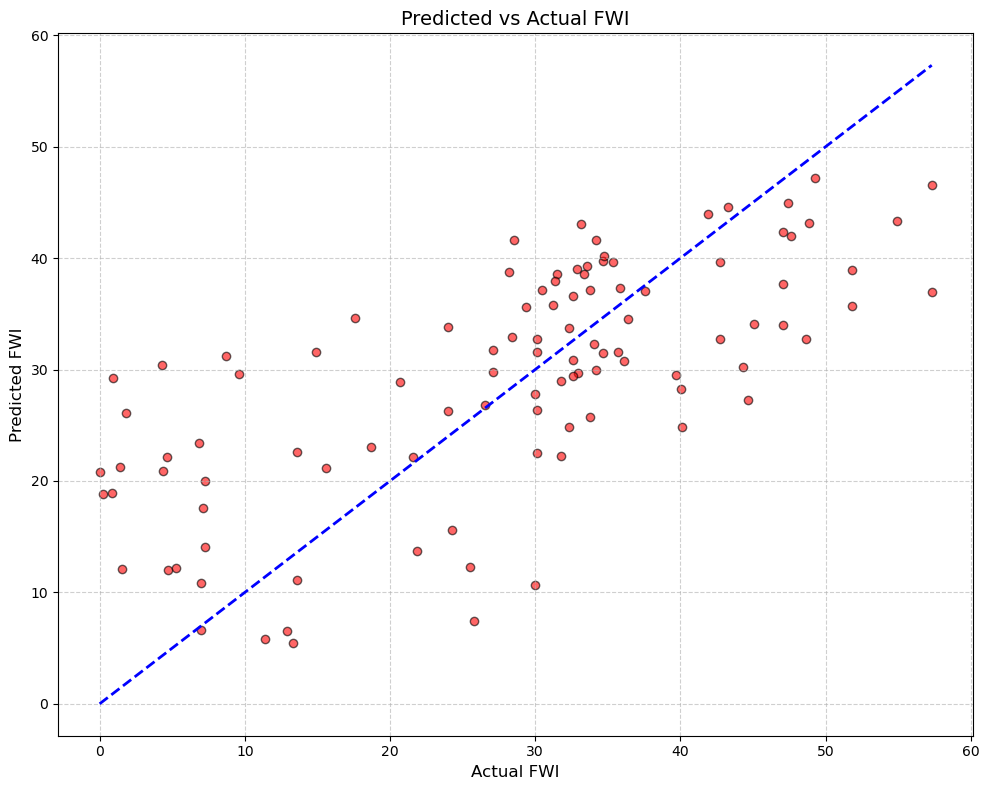

In [ ]:

def lgb_objective(trial): #objective function is defined for hyperparameter tuning 
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=False),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "random_state": 42
    }
    
    model = lgb.LGBMRegressor(**params)  #initially the model is trained for the above sample hyperparameters
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

study_lgb = optuna.create_study(direction='minimize') # the hyperparameter optimisation is run for 100 trials
study_lgb.optimize(lgb_objective, n_trials=100)
best_lgb_params = study_lgb.best_params
best_lgb_params['random_state'] = 42

lgb_model = lgb.LGBMRegressor(**best_lgb_params) #the best hyperparameters and the used to train the final Light GBM model
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

print("LightGBM R²:", r2_score(y_test, lgb_preds))

plt.figure(figsize=(10, 8))
plt.scatter(y_test, lgb_preds, color='red', alpha=0.6, edgecolor='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'b--', linewidth=2) 
plt.xlabel("Actual FWI", fontsize=12)
plt.ylabel("Predicted FWI", fontsize=12)
plt.title("Predicted vs Actual FWI", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#reference: https://forecastegy.com/posts/how-to-use-optuna-to-tune-lightgbm-hyperparameters/


Random Forest Regressor

[I 2025-11-04 21:35:26,958] A new study created in memory with name: no-name-80ceaa95-335e-4d18-9921-d1f58a13ce2b
[I 2025-11-04 21:35:27,701] Trial 0 finished with value: 11.765483960976473 and parameters: {'n_estimators': 707, 'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 6}. Best is trial 0 with value: 11.765483960976473.
[I 2025-11-04 21:35:28,503] Trial 1 finished with value: 11.76412179870308 and parameters: {'n_estimators': 807, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 6}. Best is trial 1 with value: 11.76412179870308.
[I 2025-11-04 21:35:29,240] Trial 2 finished with value: 11.950659337628034 and parameters: {'n_estimators': 763, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 1 with value: 11.76412179870308.
[I 2025-11-04 21:35:29,373] Trial 3 finished with value: 11.73045795248537 and parameters: {'n_estimators': 103, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 3 with value: 11

Random Forest R²: 0.4073480068676799


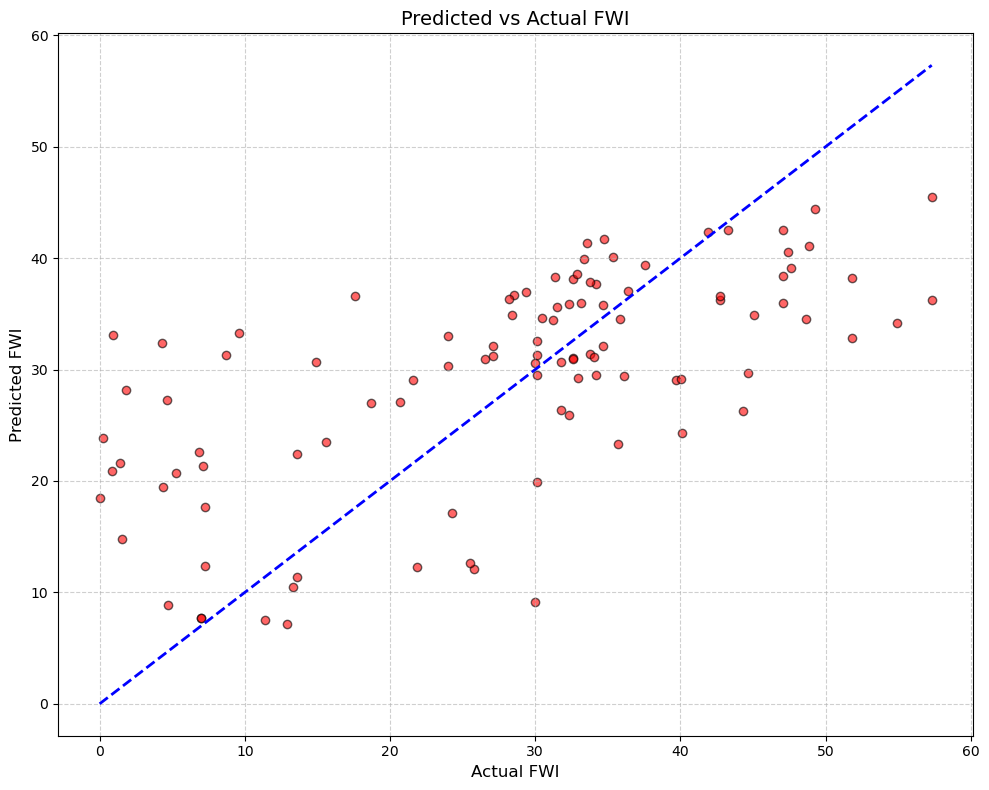

In [ ]:

def rf_objective(trial): #objective function for Optuna
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000), #total number of trees in the forest
        "max_depth": trial.suggest_int("max_depth", 3, 15), #maximum depth of each decision tree
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20), 
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "random_state": 42,
        "n_jobs": -1 #uses all CPU cores for faster computaiton
    }
    
    model = RandomForestRegressor(**params)   #random forest model is trained 
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

study_rf = optuna.create_study(direction='minimize')  #Optuna hyperparameter optimisation is conducted 
study_rf.optimize(rf_objective, n_trials=100)
best_rf_params = study_rf.best_params
best_rf_params['random_state'] = 42
best_rf_params['n_jobs'] = -1

rf_model = RandomForestRegressor(**best_rf_params)  #using best parameters the model is then trained 
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("Random Forest R²:", r2_score(y_test, rf_preds))


plt.figure(figsize=(10, 8))
plt.scatter(y_test, rf_preds, color='red', alpha=0.6, edgecolor='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'b--', linewidth=2) 
plt.xlabel("Actual FWI", fontsize=12)
plt.ylabel("Predicted FWI", fontsize=12)
plt.title("Predicted vs Actual FWI", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#reference: https://medium.com/@ehsannabatchian/optimizing-random-forest-models-a-deep-dive-into-hyperparameter-tuning-with-optuna-b8e4fe7f3670